## Imports & Helpers

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')
from checkmate_imports import *

# global variables 
HUE_ORDER = ['stroma','pred_g2','intermediate_grade','pred_g4']
MIN_SEGMENT_SIZE = 50
GRADE_DIFF_THRESH = 0.35
TUMOR_DIFF_THRESH = 0.35
MIN_TUMOR_SEG_MEAN = 0.70
NODE_DIFF_CUTOFF = invert_rag_weight(GRADE_DIFF_THRESH) 
MIN_TIL_COUNT = 10

# GRADE_TC_CUTOFF = 0.4  # minimum segment mean grade score to consider in TIL processing 
# GRADE_TC_CUTOFF = 0.  # minimum segment mean grade score to consider in TIL processing 
GRADE_TC_CUTOFF = 0.8  # focusing on high grade foci only 

print('MODIFYING EARLIER TIL CUTOFFS')
TIL_ISO_CUTOFF = 14  # based on none vs any AUROC bootstrap on high grade foci + no hard cases
TIL_HIGH_CUTOFF = 48 # based on not-high vs high AUROC bootstrap on high grade foci + no hard cases
FRAC_CUTOFF = 0.25
TIL_AREA_CUTOFF = 10

EXCLUSION_RATIO_CUTOFF = 1.5  # margin vs center ratio threshold for "exclusion" call
TILES_PER_MM2 = 0.256**-2

# assume 7x7 minimum case for a square area focus
# going 2 tiles inner would result in a 5x5 inner cube and thus area cutoff of 25
# MIN_CENTER_AREA = 25
MIN_CENTER_AREA = 10  # relaxing from 25 to try to recover possible interesting foci

MODIFYING EARLIER TIL CUTOFFS


In [2]:
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
from itertools import combinations, product

In [3]:
# feature_subset = pd.read_csv('../rerun_final_patient_features.csv', index_col=0)
feature_subset = pd.read_csv('/home/jupyter/checkmate-histo/consolidated_workflow/tcga_ricketts_rerun/rerun_final_patient_features_RICKETTS_FILTER.csv', index_col=0)

anno = pd.read_csv('../manual_cm025_merged_braunsupp_annotations.csv') 
anno['unique_id'] = 'cm025_' + anno.subjid.astype(str)
paper_desert = anno.loc[anno.ImmunoPhenotype == 'Desert','unique_id'].values
paper_infl = anno.loc[anno.ImmunoPhenotype == 'Infiltrated','unique_id'].values
paper_excl = anno.loc[anno.ImmunoPhenotype == 'Excluded','unique_id'].values
anno = anno.set_index('unique_id')

node_descriptions = pd.read_csv('../rerun_node_descriptions_with_score_components.csv',index_col=[0])
node_descriptions['merged_labels'] = node_descriptions['merged_labels'].astype(int)

prox_dist_edges = pd.read_csv('../rerun_proximal_and_distal_edge_annotations_with_score_components.csv',index_col=0)

scores = pd.read_csv('../rerun_slidewise_grade_til_scores.csv', index_col=0)

load_tile_info = False

if load_tile_info:
    tilewise_anno = pd.read_csv('../rerun_tilewise_grade_til_annotations.csv', index_col=0) # TIL specific CM025 subset

    edge_info = pd.read_csv('../rerun_base_rag_edge_info_annotation.csv', index_col=[0,1,2,3])
    # restore set objects (stored as string when saved to csv earlier)
    edge_info['edge_set'] = edge_info.reset_index()[['edge0','edge1']].apply(lambda x: set(x),1).values

    # read in non-TIL tilewise info 
    seg_agg = pd.read_csv('../rerun_tilewise_grade_nontil_annotations.csv', index_col=0)
    
    edge_agg_pivot = pd.read_csv('../rerun_base_rag_edge_info_annotation_processed.csv', index_col=[0,1,2])
    edge_class_sum = pd.read_csv('../rerun_base_rag_edge_info_annotation_processed_sum.csv', index_col=0)
    edge_binary = edge_class_sum > 0

### Override previous infiltration cutoffs to simply be based on median 

In [4]:
prev = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=True, qbins=2, mandatory_vars=[])

selecting cm025 only
(623, 148)
dropping unusable data (grade seg based)
(569, 148)
dropping entries missing any in ['os', 'os_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(558, 148)
grade quantile bins:  [0.15729222 0.77056246 0.9979857 ]
(558, 149)
dropping low tumor tile count cases
(558, 149)
dropping G1 [keeping unannotated cases]
(557, 149)
dropping metastatic biopsies
(439, 149)
keeping all stages 
(439, 149)
only keeping cases MSKCC risk group annotation
(439, 150)
converting bool edge presence labels to string


In [5]:
prev['all_nodes_area_weighted'].dropna().median()

0.1585503963759909

In [6]:
prev.groupby(['global_infiltration_bin'])['all_nodes_area_weighted'].describe()

count      mean       std       min       25%  \
global_infiltration_bin                                                      
high_hg_global_infiltration  176.0  0.370849  0.247098  0.057034  0.157776   
low_hg_global_infiltration    87.0  0.017764  0.016090  0.000000  0.004593   
no_hg_present                  0.0       NaN       NaN       NaN       NaN   

                                  50%       75%       max  
global_infiltration_bin                                    
high_hg_global_infiltration  0.337544  0.543110  0.969733  
low_hg_global_infiltration   0.013818  0.030297  0.055446  
no_hg_present                     NaN       NaN       NaN

In [7]:
MEDIAN_HG_INF_CUTOFF = 0.15855
print(f'Setting Area Infiltration Cutoff to be {MEDIAN_HG_INF_CUTOFF} based on Median')

Setting Area Infiltration Cutoff to be 0.15855 based on Median


In [8]:
crit = (feature_subset['cohort'] == 'cm025') & (feature_subset['usable_til_data']) & (feature_subset['all_nodes_area_weighted'] < MEDIAN_HG_INF_CUTOFF)

In [9]:
feature_subset.loc[crit, 'global_infiltration_bin'] = 'low_hg_global_infiltration'

In [10]:
update = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=True, qbins=2, mandatory_vars=[])

selecting cm025 only
(623, 148)
dropping unusable data (grade seg based)
(569, 148)
dropping entries missing any in ['os', 'os_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(558, 148)
grade quantile bins:  [0.15729222 0.77056246 0.9979857 ]
(558, 149)
dropping low tumor tile count cases
(558, 149)
dropping G1 [keeping unannotated cases]
(557, 149)
dropping metastatic biopsies
(439, 149)
keeping all stages 
(439, 149)
only keeping cases MSKCC risk group annotation
(439, 150)
converting bool edge presence labels to string


In [11]:
update.groupby(['global_infiltration_bin'])['all_nodes_area_weighted'].describe()

count      mean       std      min       25%  \
global_infiltration_bin                                                     
high_hg_global_infiltration  132.0  0.459134  0.223431  0.15855  0.248671   
low_hg_global_infiltration   131.0  0.047398  0.046386  0.00000  0.008805   
no_hg_present                  0.0       NaN       NaN      NaN       NaN   

                                  50%       75%       max  
global_infiltration_bin                                    
high_hg_global_infiltration  0.400099  0.619838  0.969733  
low_hg_global_infiltration   0.030429  0.087560  0.155452  
no_hg_present                     NaN       NaN       NaN

In [12]:
NONKM_FONT_SCALE = 1.8
KM_FONT_SCALE = 1.2

### Fig 1: ROC Curve KIRC G2 vs G4

(262, 148)
(249, 148)


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


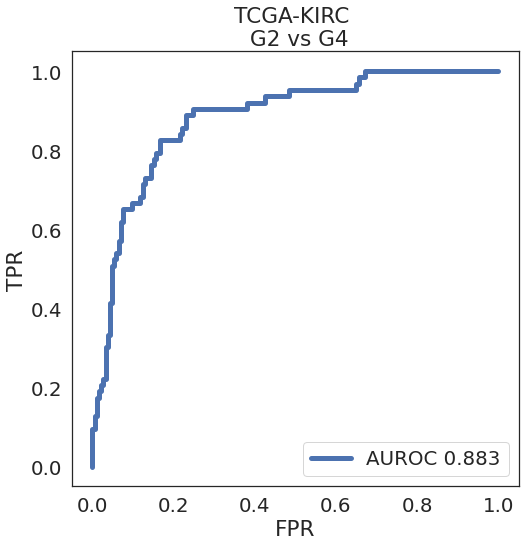

In [13]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, roc_curve, confusion_matrix, plot_confusion_matrix

temp = feature_subset.loc[(feature_subset.cohort =='kirc') & (feature_subset.grade.isin(['G2','G4']))]
print(temp.shape)
temp = temp.loc[~temp['nonstroma_grade_mean'].isna()]
print(temp.shape)
temp['g4_not_g2'] = (temp.grade == 'G4').astype(int)
temp['slide_pred'] = (temp['nonstroma_grade_mean'] > 0.5).astype(int)
temp['correct_slide_pred'] = temp['g4_not_g2'] == temp['slide_pred']
temp['correct_slide_pred'].mean()

score = roc_auc_score(temp['g4_not_g2'], temp['nonstroma_grade_mean'])
fpr, tpr, thresh =  roc_curve(temp['g4_not_g2'], temp['nonstroma_grade_mean'])

set_rc(8,8, NONKM_FONT_SCALE)

plt.plot(fpr, tpr, label=f'AUROC {score:.3f}', linewidth=5)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('TCGA-KIRC \n G2 vs G4')
plt.legend(loc='lower right')
plt.savefig('./main_figs/kirc_auroc.pdf', bbox_inches='tight')
plt.show()

### Fig 1: Grade Score by Cohort 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

TCGA-KIRC_G2 v.s. TCGA-KIRC_G4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.011e-18 U_stat=1.374e+03
DFCI-PROFILE_G4 v.s. DFCI-PROFILE_G3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.688e-10 U_stat=5.379e+03
CM-025_G4 v.s. CM-025_G3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.502e-09 U_stat=5.425e+03
CM-025_G2 v.s. CM-025_G4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.605e-19 U_stat=3.120e+02
DFCI-PROFILE_G2 v.s. DFCI-PROFILE_G4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.683e-20 U_stat=3.620e+02
TCGA-KIRC_G4 v.s. TCGA-KIRC_G3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.289e-09 U_stat=8.220e+03
CM-025_G2 v.s. CM-025_G3: Mann-Whitney-Wilcoxon test two

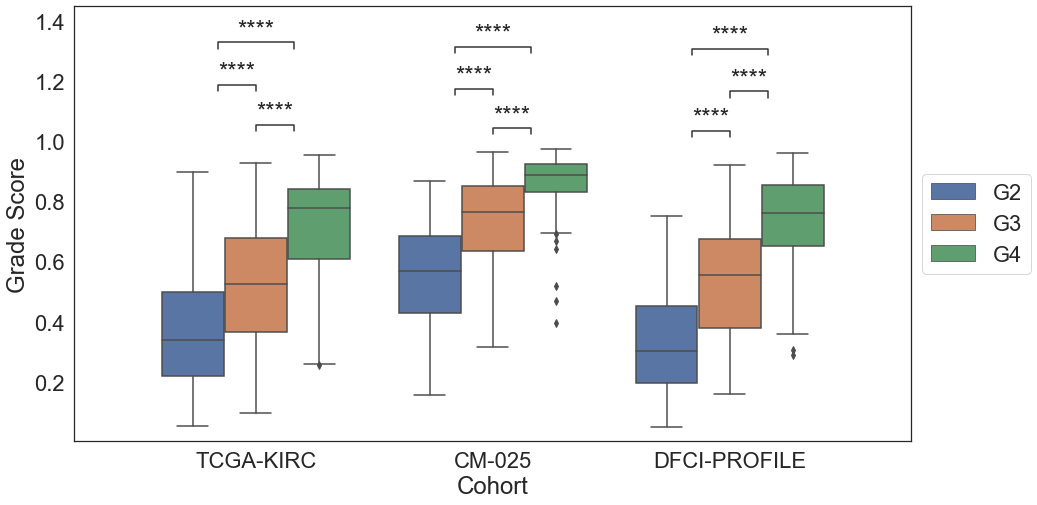

In [14]:
# %%capture
set_rc(15,8, 2)
sns.set_style('white')

data = feature_subset.copy()
data['cohort'] = data['cohort'].str.upper()
data['cohort'] = data['cohort'].replace({'KIRC':'TCGA-KIRC','CM025':'CM-025','PROFILE':'DFCI-PROFILE'})

x = 'cohort'
y = 'updated_nonstroma_grade_mean'
hue = 'grade'

hue_order = ['G2','G3','G4']
order = [x.upper() for x in ['tcga-kirc','cm-025','dfci-profile']]
box_pairs = []
[box_pairs.extend(list(combinations([(cohort,x) for x in ['G2','G3','G4']], 2))) for cohort in ['TCGA-KIRC','CM-025','DFCI-PROFILE']]


g = sns.boxplot(x=x, order=order, hue=hue, hue_order=hue_order, y=y, data=data)
move_leg(g, x=1)
test_results = add_stat_annotation(g, data=data, x=x, y=y, hue=hue,
                                   box_pairs=box_pairs,
                                   test='Mann-Whitney', text_format='star',
                                   loc='inside', verbose=2)
test_results

plt.ylabel('Grade Score')
plt.xlabel('Cohort')


plt.savefig(f'./main_figs/{y}_vs_{hue}_all_cohorts_signif_test_marker_wide_box.pdf', bbox_inches='tight')

In [15]:
# %%capture
# kirc_data = prepare_generic_subset(feature_subset, 'kirc', relabel_edge_cats=False)
# profile_data = prepare_generic_subset(feature_subset, 'profile', relabel_edge_cats=False)
# checkmate_data = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=False)

# filtered_agg_data = pd.concat([kirc_data, profile_data, checkmate_data])

In [16]:
# %%capture
kirc_data = prepare_generic_subset(feature_subset, 'kirc', relabel_edge_cats=False)
checkmate_data = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=False)

filtered_agg_data = pd.concat([kirc_data, checkmate_data])

selecting kirc
(465, 148)
dropping unusable data (grade seg based)
(431, 148)
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(431, 148)
grade quantile bins:  [0.0524563  0.34008044 0.5945049  0.95407209]
(431, 149)
dropping low tumor tile count cases
(431, 149)
dropping G1 [keeping unannotated cases]
(421, 149)
dropping metastatic biopsies
(421, 149)
keeping all stages 
(421, 149)
selecting cm025 only
(623, 148)
dropping unusable data (grade seg based)
(569, 148)
dropping entries missing any in ['os', 'os_event', 'age_at_diagnosis', 'gender']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(542, 148)
grade quantile bins:  [0.15729222 0.68477528 0.84331957 0.9979857 ]
(542, 149)
dropping low tumor tile count cases
(542, 149)
dropping G1 [keeping unannotated cases]
(541, 149)
dropping metastatic biopsies
(427, 149)
keeping all stages 
(427, 149)
only keeping cases MSKCC risk group annotation
(427, 150)


### Edge vs Driver Plots [Count]

In [17]:
set_rc(8,8, 1.7)

===== all_rag_edge_total =====


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:1.154e-01 U_stat=1.528e+04
CM-025_WT vs. CM-025_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:4.592e-03 U_stat=5.631e+03


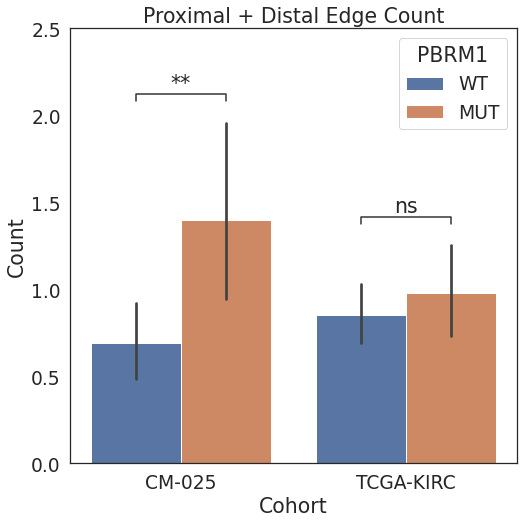

===== edge_class_proximal =====
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:6.442e-02 U_stat=1.506e+04
CM-025_WT vs. CM-025_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:1.329e-03 U_stat=5.523e+03


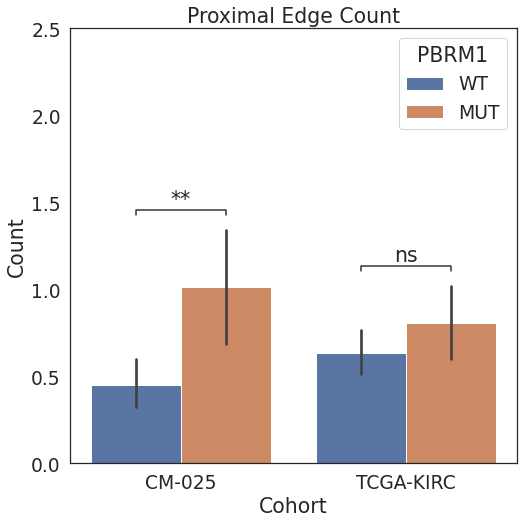

===== edge_class_distal =====
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:8.031e-01 U_stat=1.696e+04
CM-025_WT vs. CM-025_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:3.645e-01 U_stat=6.635e+03


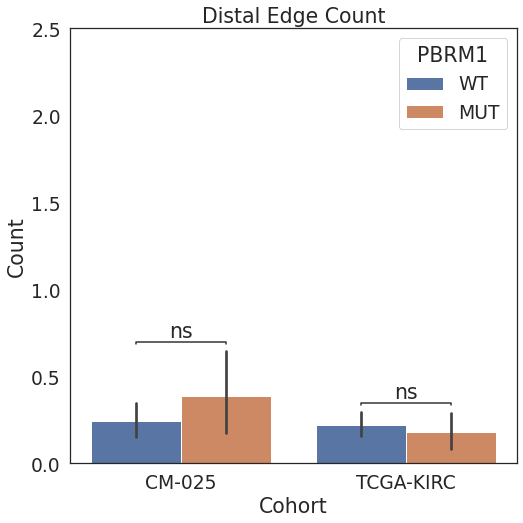

===== all_rag_edge_total =====
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:7.195e-01 U_stat=4.212e+03
CM-025_WT vs. CM-025_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:2.659e-02 U_stat=5.426e+03


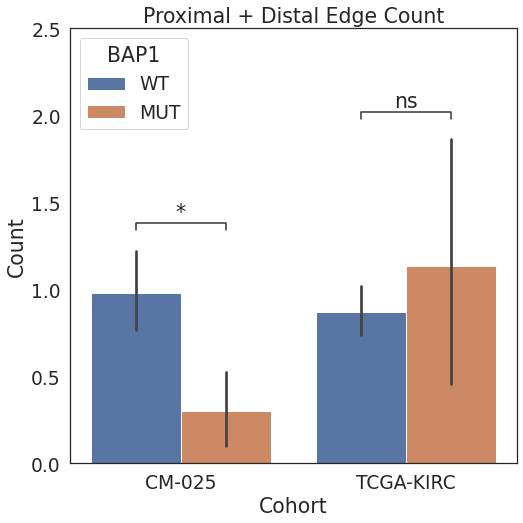

===== edge_class_proximal =====
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:7.034e-01 U_stat=4.573e+03
CM-025_WT vs. CM-025_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:9.155e-02 U_stat=5.195e+03


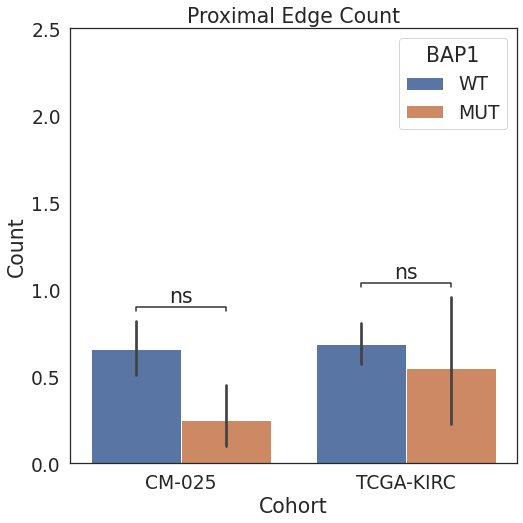

===== edge_class_distal =====
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:4.024e-02 U_stat=3.712e+03
CM-025_WT vs. CM-025_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:2.824e-02 U_stat=5.227e+03


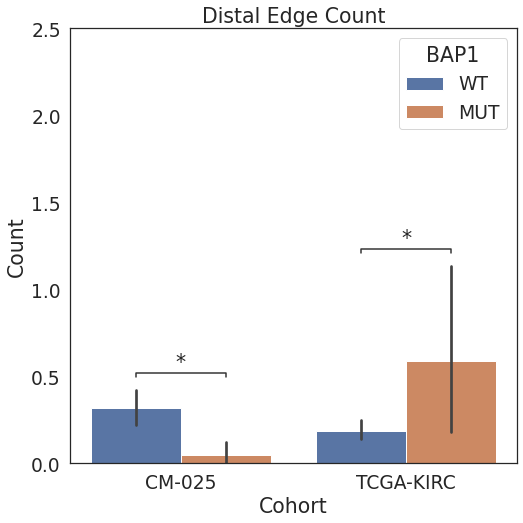

===== all_rag_edge_total =====
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:2.218e-01 U_stat=4.658e+03
CM-025_WT vs. CM-025_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:9.097e-02 U_stat=5.078e+03


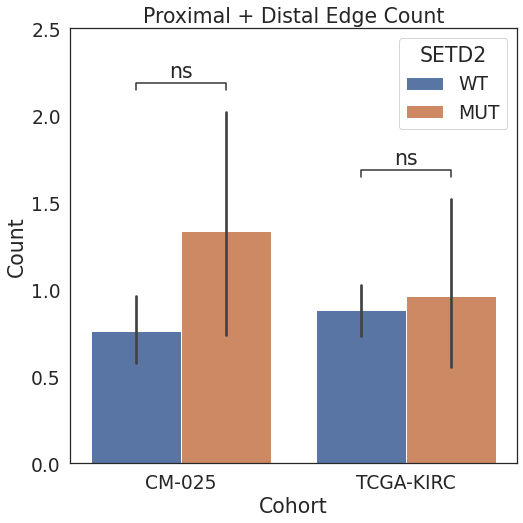

===== edge_class_proximal =====
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:1.583e-01 U_stat=4.570e+03
CM-025_WT vs. CM-025_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:9.264e-02 U_stat=5.115e+03


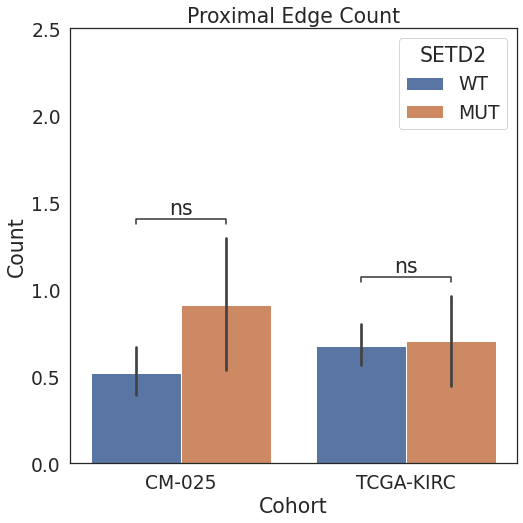

===== edge_class_distal =====
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:8.429e-01 U_stat=5.246e+03
CM-025_WT vs. CM-025_MUT: Mann-Whitney-Wilcoxon test two-sided, P_val:3.548e-01 U_stat=5.498e+03


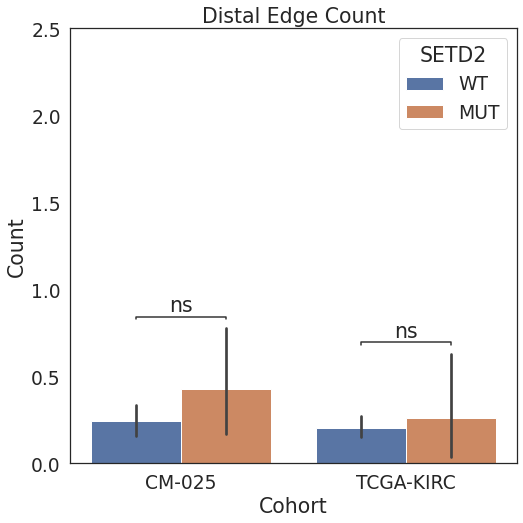

In [18]:
# %%capture
col_rename = {
    'all_rag_edge_total':'Proximal + Distal Edge Count',
    'edge_class_proximal':'Proximal Edge Count',
    'edge_class_distal':'Distal Edge Count',
}

gene = 'PBRM1'
df = filtered_agg_data.loc[filtered_agg_data[gene] != 'no_info']
df['Cohort'] = df['cohort'].str.upper()
df['Cohort'] = df['Cohort'].replace({'KIRC':'TCGA-KIRC','CM025':'CM-025', 'PROFILE':'DFCI-PROFILE'})

x = 'Cohort'
for gene in ['PBRM1','BAP1','SETD2']:
    for y in ['all_rag_edge_total','edge_class_proximal','edge_class_distal']:
        print(f'===== {y} =====')
        order = [x.upper() for x in ['cm-025','tcga-kirc']]
        hue = gene
        hue_order = ['WT','MUT']

        df = df.dropna(subset=[x,y,hue])


        g = sns.barplot(x=x, order=order, y=y, hue=hue, data=df,
                     hue_order=hue_order,)

        # pairs = list(combinations(product(df[x].unique(), df[hue].unique()), 2))
        pairs = [list(product([cohort], df[hue].unique())) for cohort in df[x].unique()]

        annotator = Annotator(g, pairs, order=order, data=df, x=x, y=y, hue=hue, hue_order=hue_order)
        annotator.configure(test='Mann-Whitney', text_format='star')
        annotator.apply_and_annotate()
        plt.ylim(0,2.5)
        plt.title(col_rename[y])
        plt.ylabel('Count')
        plt.savefig(f'./main_figs/{y}_count_vs_{gene}_status_all_cohorts.pdf', bbox_inches='tight')
        plt.show()

### Edge vs Driver Plots [Frequency]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Custom statistical test, P_val:8.880e-02
CM-025_WT vs. CM-025_MUT: Custom statistical test, P_val:1.861e-02


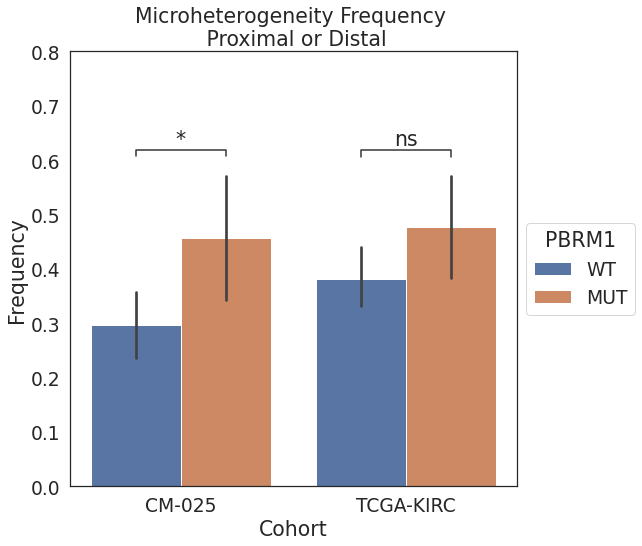

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Custom statistical test, P_val:6.633e-02
CM-025_WT vs. CM-025_MUT: Custom statistical test, P_val:5.789e-03


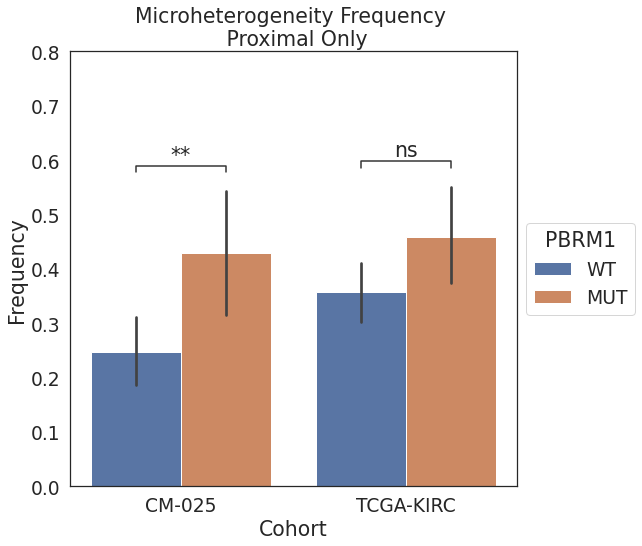

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Custom statistical test, P_val:1.000e+00
CM-025_WT vs. CM-025_MUT: Custom statistical test, P_val:4.565e-01


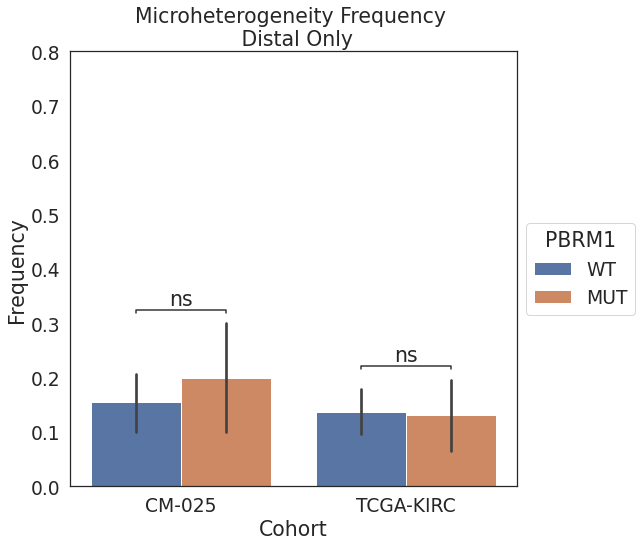

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Custom statistical test, P_val:1.000e+00
CM-025_WT vs. CM-025_MUT: Custom statistical test, P_val:4.778e-02


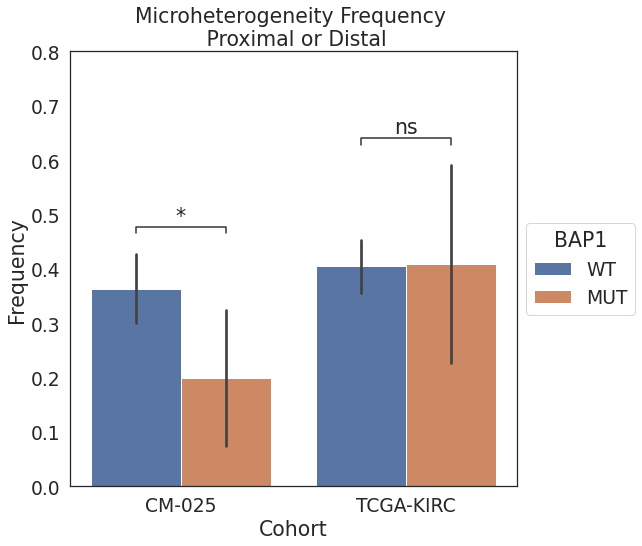

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Custom statistical test, P_val:1.000e+00
CM-025_WT vs. CM-025_MUT: Custom statistical test, P_val:1.899e-01


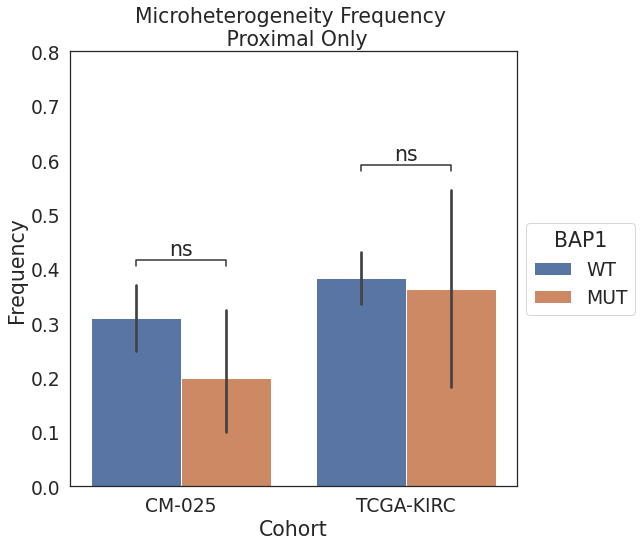

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Custom statistical test, P_val:9.906e-02
CM-025_WT vs. CM-025_MUT: Custom statistical test, P_val:3.663e-02


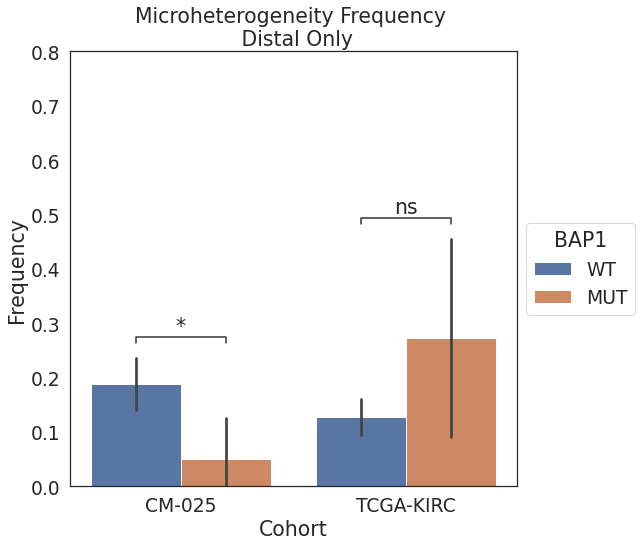

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Custom statistical test, P_val:1.094e-01
CM-025_WT vs. CM-025_MUT: Custom statistical test, P_val:1.482e-01


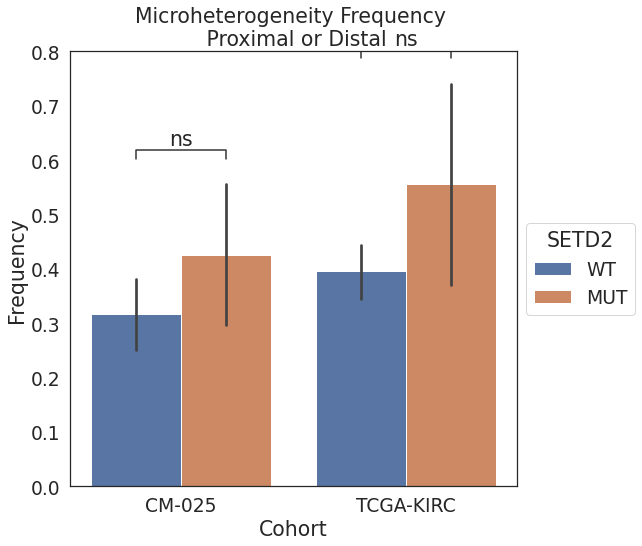

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Custom statistical test, P_val:6.603e-02
CM-025_WT vs. CM-025_MUT: Custom statistical test, P_val:1.828e-01


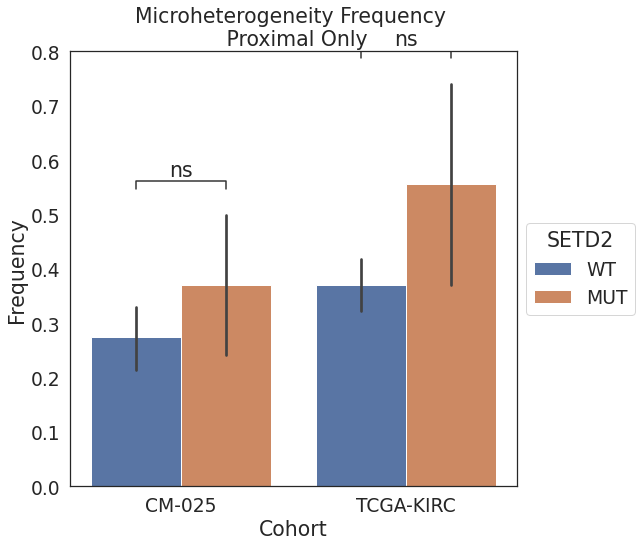

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_MUT: Custom statistical test, P_val:7.737e-01
CM-025_WT vs. CM-025_MUT: Custom statistical test, P_val:4.193e-01


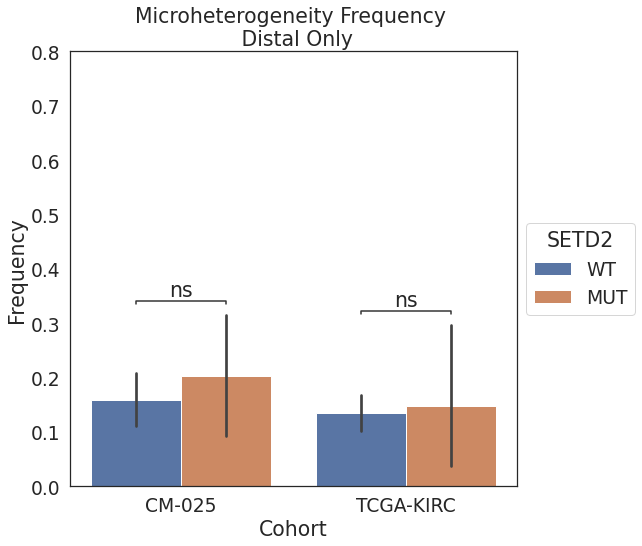

In [19]:
# %%capture
gene = 'PBRM1'
df = filtered_agg_data.loc[filtered_agg_data[gene] != 'no_info']
df['Cohort'] = df['cohort'].str.upper()
df['Cohort'] = df['Cohort'].replace({'KIRC':'TCGA-KIRC','CM025':'CM-025', 'PROFILE':'DFCI-PROFILE'})

x = 'Cohort'
y = 'any_diff_edge'

freq_map = {
    'any_diff_edge':'Proximal or Distal',
    'any_proximal_edge':'Proximal Only',
    'any_distal_edge':'Distal Only'
}

for gene in ['PBRM1','BAP1','SETD2']:
    for y in ['any_diff_edge','any_proximal_edge','any_distal_edge']:
        order = [x.upper() for x in ['cm-025','tcga-kirc']]
        hue = gene
        hue_order = ['WT','MUT']

        conting_upstream = df.set_index([x,hue])[y].reset_index().value_counts([x,hue,y],sort=False)
        manual_fisher_pvals = {cohort:fisher_exact(conting_upstream.loc[cohort].values.reshape((2,2)))[1] for cohort in order}


        df = df.dropna(subset=[x,y,hue])


        g = sns.barplot(x=x, order=order, y=y, hue=hue, data=df,
                     hue_order=hue_order,)
        g.legend(title=gene,loc='center left', bbox_to_anchor=(1., 0.5), ncol=1)

        pairs = [list(product([cohort], df[hue].unique())) for cohort in order]
        pvals = [manual_fisher_pvals[x[0][0]] for x in pairs]

        annotator = Annotator(g, pairs, data=df, x=x, y=y, hue=hue, order=order, hue_order=hue_order)
        annotator.set_pvalues(pvals)
        annotator.annotate()
        plt.ylabel('Frequency')
        plt.title(f'Microheterogeneity Frequency \n {freq_map[y]}')
        plt.ylim(0,0.8)
        plt.savefig(f'./main_figs/{y}_frequency_vs_{gene}_status_all_cohorts.pdf', bbox_inches='tight')
        plt.show()


### bootstrapped continuous vs categorical c-index

In [20]:
kirc_data.value_counts('grade')

grade
G2    186
G3    170
G4     63
GX      2
dtype: int64

In [21]:
# %%capture
try:
    comp_df = pd.read_csv('./bootstrapped_cindex_continuous_vs_categorical_grade_kirc.csv')
#     raise Error 
    
except:
    mandatory_vars = ['os','os_event','pfs','pfs_event']
    comparison = {}

    duration_var = 'os'
    event_var = f'{duration_var}_event'
    n_folds=2
    score_method='concordance_index'
    l1_ratio = 0.
    penalizer = 0.1

    df = prepare_generic_subset(feature_subset, 'kirc', mandatory_vars=mandatory_vars)
    cph = CoxPHFitter(l1_ratio=l1_ratio, penalizer=penalizer)

    grade_var_mapper = {
        'grade':'categorical',
        'nonstroma_grade_mean':'continuous',
    }

    for duration_var in ['os','pfs']:
        event_var = f'{duration_var}_event'
        for grade_var in ['grade','nonstroma_grade_mean']:
            grade_var_type = grade_var_mapper[grade_var]
            temp_result = []
            for bootstrap_iter in range(50):
                df_sub = df.sample(frac=0.8)
                cph.fit(df=df_sub.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':grade_var})
                out = cph.concordance_index_
                temp_result.append(out)

            comparison[f'{duration_var}_{grade_var_type}'] = temp_result
    comp_df = pd.DataFrame(comparison).melt()

    comp_df['Grade Type'] = comp_df['variable'].apply(lambda x: x.split('_')[1].title())
    comp_df['Survival Type'] = comp_df['variable'].apply(lambda x: x.split('_')[0].upper())
    comp_df = comp_df.rename(columns={'value':'C-Index'})
    comp_df.to_csv('./bootstrapped_cindex_continuous_vs_categorical_grade_kirc.csv')


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

OS_Categorical vs. OS_Continuous: Mann-Whitney-Wilcoxon test two-sided, P_val:1.628e-02 U_stat=1.599e+03
PFS_Categorical vs. PFS_Continuous: Mann-Whitney-Wilcoxon test two-sided, P_val:2.025e-11 U_stat=2.770e+02


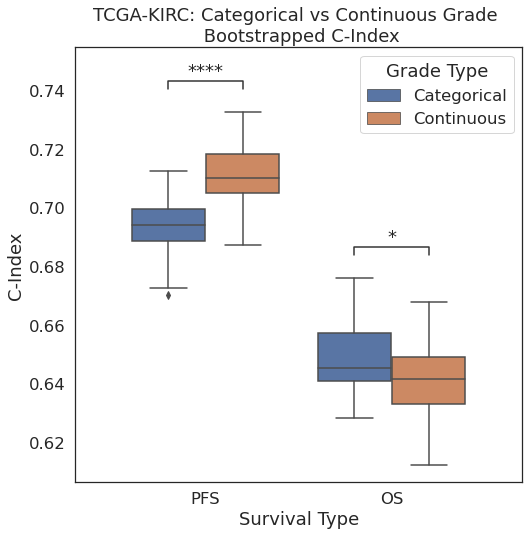

In [22]:
df = comp_df.copy()

plot_kws = {
    'order':['PFS','OS'],
    'x':'Survival Type',
    'y':'C-Index',
    'hue':'Grade Type',
    'hue_order':['Categorical','Continuous'],
    'data':df
}

set_rc(8,8, 1.5)
g = sns.boxplot(**plot_kws)
pairs = [list(product([x_val], df[plot_kws['hue']].unique())) for x_val in df[plot_kws['x']].unique()]
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()
plt.title('TCGA-KIRC: Categorical vs Continuous Grade \n Bootstrapped C-Index')
plt.savefig('./main_figs/categorical_vs_continuous_grade_bootstrapped_cindex.pdf', bbox_inches='tight')

In [23]:
comp_df.groupby(['variable'])['C-Index'].describe()

count      mean       std       min       25%       50%  \
variable                                                                   
os_categorical    50.0  0.648405  0.011257  0.628312  0.640907  0.645427   
os_continuous     50.0  0.641502  0.012769  0.612389  0.633157  0.641458   
pfs_categorical   50.0  0.693827  0.009929  0.670271  0.688508  0.694191   
pfs_continuous    50.0  0.711013  0.010245  0.687375  0.704829  0.710031   

                      75%       max  
variable                             
os_categorical   0.657208  0.675851  
os_continuous    0.649247  0.667996  
pfs_categorical  0.699490  0.712589  
pfs_continuous   0.718380  0.732559

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

OS_Categorical vs. OS_Continuous: Mann-Whitney-Wilcoxon test two-sided, P_val:1.628e-02 U_stat=1.599e+03
PFS_Categorical vs. PFS_Continuous: Mann-Whitney-Wilcoxon test two-sided, P_val:2.025e-11 U_stat=2.770e+02


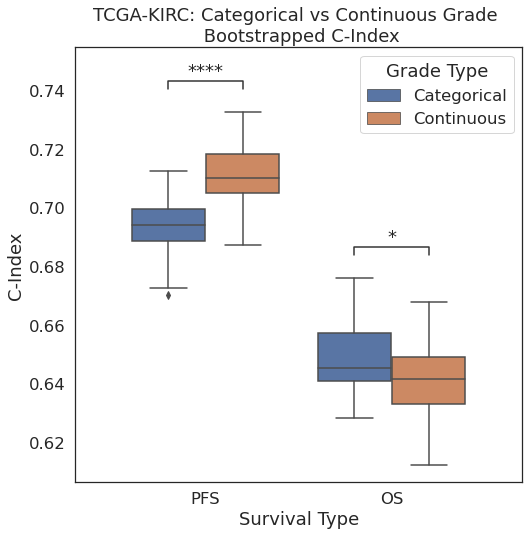

In [24]:
df = comp_df.copy()

plot_kws = {
    'order':['PFS','OS'],
    'x':'Survival Type',
    'y':'C-Index',
    'hue':'Grade Type',
    'hue_order':['Categorical','Continuous'],
    'data':df
}

set_rc(8,8, 1.5)
g = sns.boxplot(**plot_kws)
pairs = [list(product([x_val], df[plot_kws['hue']].unique())) for x_val in df[plot_kws['x']].unique()]
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()
plt.title('TCGA-KIRC: Categorical vs Continuous Grade \n Bootstrapped C-Index')
plt.savefig('./main_figs/categorical_vs_continuous_grade_bootstrapped_cindex.pdf', bbox_inches='tight')

In [25]:
# rerun_expanded_bootstrap = False
# if rerun_expanded_bootstrap:
#     data_subset = feature_subset.copy()

#     try:
#         client.close()
#     except:
#         pass

#     client = Client()

#     store = []
#     completed = []  
#     filtered_data_store = {}
#     meta_agg = []

#     bootstrap_fraction = 0.5
#     bootstrap_iter = 500


#     sweep_params = {'l1_ratio':0., 'penalizer':0.1}
#     unscaled_cols = ['nonstroma_grade_mean']

#     df = prepare_generic_subset(data_subset, 'kirc', mandatory_vars=mandatory_vars)

#     for duration_var in ['os','pfs']:
#         event_var = duration_var+'_event'
#         for bootstrap_iter in range(bootstrap_iter):

#             df_sub = df.sample(frac=bootstrap_fraction)


#             df_sub[unscaled_cols] = run_cph_feature_scaling(df_sub, unscaled_cols)

#             identifiers = {'duration_var':duration_var, 'bootstrap_iter':bootstrap_iter, 
#                           'penalizer':sweep_params['penalizer'], 'l1_ratio':sweep_params['l1_ratio']}

#             for formula in ['grade','nonstroma_grade_mean']:
#                 big_future = client.scatter(df_sub)
#                 f = client.submit(run_cph_fitting_dask, df=big_future, duration_var=duration_var, event_var=event_var, covariate_formula=formula, 
#                                   split_name=(duration_var, formula, bootstrap_iter), penalizer=sweep_params['penalizer'], l1_ratio=sweep_params['l1_ratio'], identifiers=identifiers)
#                 store.append(f)

#     for future, output in dask.distributed.as_completed(store, with_results = True, raise_errors=True):
#         completed.append(output)
#     client.close()

#     cph_results = {}
#     result_agg = []

#     result_agg = {}
#     for output in completed:
#         try:
#             cph = output['cph']
#             result_agg[output['split_name']] = cph.concordance_index_

#         except Exception as e :
#             print(e)
#             pass


#     result_agg = pd.Series(result_agg)
#     result_agg.name = 'C-Index'

#     result_agg.index.names = ['duration','var','iteration']

#     result_agg = result_agg.reset_index()

#     result_agg['Grade Type'] = result_agg['var'].map({
#             'grade':'categorical',
#             'nonstroma_grade_mean':'continuous',
#         }).str.title()

#     result_agg['Survival Type'] = result_agg['duration'].str.upper()
    
#     result_agg.to_csv(f'./bootstrapped_cindex_continuous_vs_categorical_grade_kirc_expanded_frac{bootstrap_fraction}_iter{bootstrap_iter}.csv')
# else:
#     bootstrap_fraction = 0.5
#     bootstrap_iter = 500
#     result_agg = pd.read_csv(f'./bootstrapped_cindex_continuous_vs_categorical_grade_kirc_expanded_frac{bootstrap_fraction}_iter{bootstrap_iter}.csv')

# df = result_agg.copy()
# plot_kws = {
#     'order':['PFS','OS'],
#     'x':'Survival Type',
#     'y':'C-Index',
#     'hue':'Grade Type',
#     'hue_order':['Categorical','Continuous'],
#     'data':df,
# }

# set_rc(8,8, 1.5)
# g = sns.violinplot(**plot_kws)
# pairs = [list(product([x_val], df[plot_kws['hue']].unique())) for x_val in df[plot_kws['x']].unique()]
# annotator = Annotator(g, pairs, **plot_kws)
# annotator.configure(test='Mann-Whitney', text_format='star')
# annotator.apply_and_annotate()

### Print out c-index if we just grab all of it 

In [26]:
mandatory_vars = ['os','os_event','pfs','pfs_event']
comparison = {}

duration_var = 'os'
event_var = f'{duration_var}_event'
n_folds=2
score_method='concordance_index'
l1_ratio = 0.
penalizer = 0.1

df = prepare_generic_subset(feature_subset, 'kirc', mandatory_vars=mandatory_vars)
cph = CoxPHFitter(l1_ratio=l1_ratio, penalizer=penalizer)

grade_var_mapper = {
    'grade':'categorical',
    'nonstroma_grade_mean':'continuous',
}

for duration_var in ['os','pfs']:
    event_var = f'{duration_var}_event'
    for grade_var in ['grade','nonstroma_grade_mean']:
        grade_var_type = grade_var_mapper[grade_var]
        temp_result = []
        for bootstrap_iter in range(1):
            df_sub = df.sample(frac=1)
            cph.fit(df=df_sub.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':grade_var})
            out = cph.concordance_index_
            temp_result.append(out)

        comparison[f'{duration_var}_{grade_var_type}'] = temp_result
comp_df = pd.DataFrame(comparison).melt()

comp_df['Grade Type'] = comp_df['variable'].apply(lambda x: x.split('_')[1].title())
comp_df['Survival Type'] = comp_df['variable'].apply(lambda x: x.split('_')[0].upper())
comp_df = comp_df.rename(columns={'value':'C-Index'})

selecting kirc
(465, 148)
dropping unusable data (grade seg based)
(431, 148)
dropping entries missing any in ['os', 'os_event', 'pfs', 'pfs_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(429, 148)
grade quantile bins:  [0.0524563  0.33959318 0.58796686 0.95407209]
(429, 149)
dropping low tumor tile count cases
(429, 149)
dropping G1 [keeping unannotated cases]
(419, 149)
dropping metastatic biopsies
(419, 149)
keeping all stages 
(419, 149)
converting bool edge presence labels to string


In [27]:
comp_df

variable   C-Index   Grade Type Survival Type
0   os_categorical  0.647609  Categorical            OS
1    os_continuous  0.639923   Continuous            OS
2  pfs_categorical  0.691366  Categorical           PFS
3   pfs_continuous  0.712617   Continuous           PFS

### Average Proximal Degree [pre-expansion]

In [28]:
# %%capture
# col_rename = {
#     'avg_degree':'Average Proximal Degree'
# }

# set_rc(8,8, 2)
# gene = 'PBRM1'
# df = filtered_agg_data.loc[filtered_agg_data[gene] != 'no_info']
# df['Cohort'] = df['cohort'].str.upper()

# x = 'Cohort'
# for gene in ['PBRM1','BAP1','SETD2']:
#     for y in ['avg_degree']:
#         print(f'===== {y} =====')
#         order = [x.upper() for x in ['cm025','kirc','profile']]
#         hue = gene
#         hue_order = ['WT','MUT']

#         df = df.dropna(subset=[x,y,hue])


#         g = sns.barplot(x=x, order=order, y=y, hue=hue, data=df,
#                      hue_order=hue_order,)

#         # pairs = list(combinations(product(df[x].unique(), df[hue].unique()), 2))
#         pairs = [list(product([cohort], df[hue].unique())) for cohort in df[x].unique()]

#         annotator = Annotator(g, pairs, order=order, data=df, x=x, y=y, hue=hue, hue_order=hue_order)
#         annotator.configure(test='Mann-Whitney', text_format='star')
#         annotator.apply_and_annotate()
#         plt.ylim(0,1.75)
#         plt.title(col_rename[y])
#         plt.ylabel('Average Graph Degree')
#         plt.savefig(f'./main_figs/{y}_count_vs_{gene}_status_all_cohorts.pdf', bbox_inches='tight')
#         plt.show()

### 9p21.3 

In [29]:
set_rc(8,8, 1.5)

In [30]:
kirc_9p = pd.read_csv('../kirc_gistic_9p213_labeled.csv',index_col=0)

anno['9p21.3'] = anno['Deletion_9p21.3'].map({'MUT':'LOSS','WT':'WT'})

### 9p21.3 vs edge

selecting kirc
(465, 148)
dropping unusable data (grade seg based)
(431, 148)
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(431, 148)
grade quantile bins:  [0.0524563  0.46054733 0.95407209]
(431, 149)
dropping low tumor tile count cases
(431, 149)
dropping G1 [keeping unannotated cases]
(421, 149)
dropping metastatic biopsies
(421, 149)
keeping all stages 
(421, 149)
selecting cm025 only
(623, 148)
dropping unusable data (grade seg based)
(569, 148)
dropping entries missing any in ['os', 'os_event', 'age_at_diagnosis', 'gender']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(542, 148)
grade quantile bins:  [0.15729222 0.76791894 0.9979857 ]
(542, 149)
dropping low tumor tile count cases
(542, 149)
dropping G1 [keeping unannotated cases]
(541, 149)
dropping metastatic biopsies
(427, 149)
keeping all stages 
(427, 149)
only keeping cases MSKCC risk group annotation
(427, 150)
only grabbing Stage IV KIRC + above median GS
p-value a

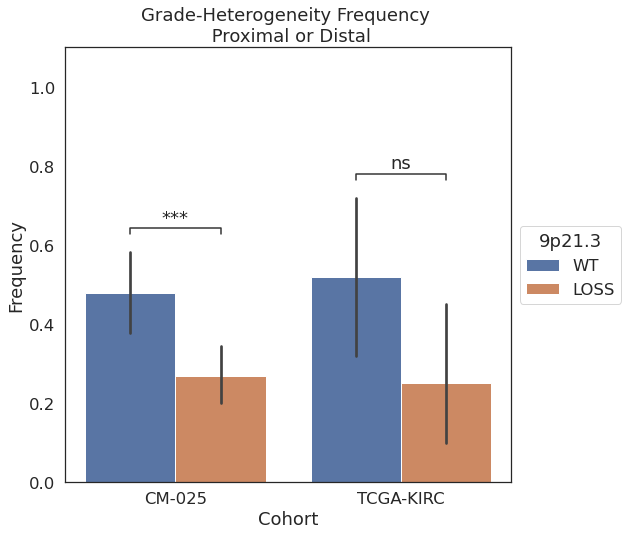

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_LOSS: Custom statistical test, P_val:6.611e-02
CM-025_WT vs. CM-025_LOSS: Custom statistical test, P_val:2.289e-04


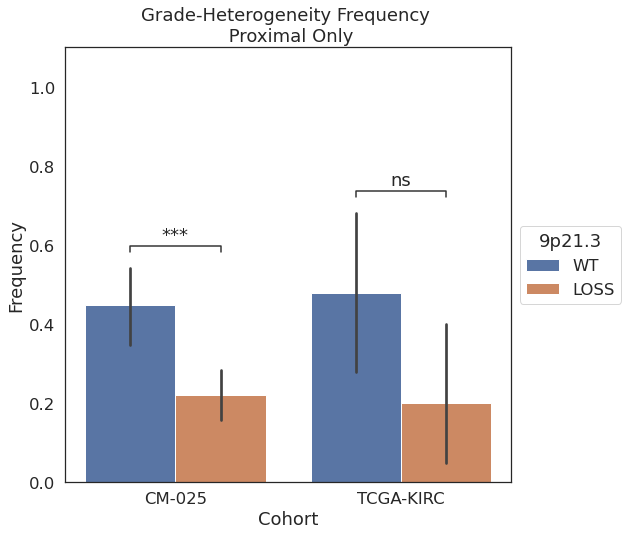

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_WT vs. TCGA-KIRC_LOSS: Custom statistical test, P_val:3.087e-01
CM-025_WT vs. CM-025_LOSS: Custom statistical test, P_val:1.247e-01


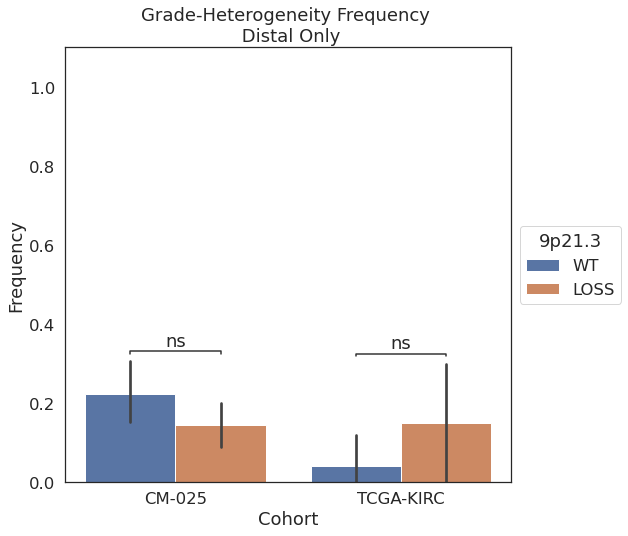

In [31]:
# %%capture
qbins = 2
kirc_data = prepare_generic_subset(feature_subset, 'kirc', relabel_edge_cats=False, qbins=qbins)
checkmate_data = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=False, qbins=qbins)

filtered_agg_data = pd.concat([kirc_data, checkmate_data])
filtered_agg_data = filtered_agg_data.join(pd.concat([anno[['9p21.3']], kirc_9p]))

df = filtered_agg_data.loc[filtered_agg_data['9p21.3'].isin(['WT','LOSS'])]
print('only grabbing Stage IV KIRC + above median GS')
df = df.loc[(df['cohort'] == 'cm025') | ((df['cohort'] == 'kirc') & (df['stage'] == 'Stage IV') & (df['quantile_bin'] == 'quantile_bin_1'))]

# df = df.loc[(df['cohort'] == 'cm025') | ((df['cohort'] == 'kirc') & (df['quantile_bin'] == 'quantile_bin_1'))]

# df = df.loc[(df['cohort'] == 'cm025') | ((df['cohort'] == 'kirc') & (df['stage'] == 'Stage IV'))]

df['Cohort'] = df['cohort'].str.upper()
df['Cohort'] = df['Cohort'].replace({'KIRC':'TCGA-KIRC','CM025':'CM-025', 'PROFILE':'DFCI-PROFILE'})
df['9p21.3_ind'] = df['9p21.3'] == 'LOSS'

x = 'Cohort'
y = 'any_diff_edge'

freq_map = {
    'any_diff_edge':'Proximal or Distal',
    'any_proximal_edge':'Proximal Only',
    'any_distal_edge':'Distal Only'
}

for gene in ['9p21.3']:
    for y in ['any_diff_edge','any_proximal_edge','any_distal_edge']:
        order = [x.upper() for x in ['cm-025','tcga-kirc']]
        hue = gene
        hue_order = ['WT','LOSS']

        conting_upstream = df.set_index([x,hue])[y].reset_index().value_counts([x,hue,y],sort=False)
        manual_fisher_pvals = {cohort:fisher_exact(conting_upstream.loc[cohort].values.reshape((2,2)))[1] for cohort in order}


        df = df.dropna(subset=[x,y,hue])


        g = sns.barplot(x=x, order=order, y=y, hue=hue, data=df,
                     hue_order=hue_order,)
        g.legend(title=gene,loc='center left', bbox_to_anchor=(1., 0.5), ncol=1)

        pairs = [list(product([cohort], df[hue].unique())) for cohort in order]
        pvals = [manual_fisher_pvals[x[0][0]] for x in pairs]

        annotator = Annotator(g, pairs, data=df, x=x, y=y, hue=hue, order=order, hue_order=hue_order)
        annotator.set_pvalues(pvals)
        annotator.annotate()
        plt.ylabel('Frequency')
        plt.title(f'Grade-Heterogeneity Frequency \n {freq_map[y]}')
        plt.ylim(0,1.1)
        plt.savefig(f'./main_figs/{y}_frequency_vs_9p213_status__cm025_all__kirc_stage4_abovemedianGS.pdf', bbox_inches='tight')
        plt.show()


### 9p21.3 vs driver

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_False vs. TCGA-KIRC_True: Custom statistical test, P_val:4.655e-01
CM-025_False vs. CM-025_True: Custom statistical test, P_val:9.993e-04


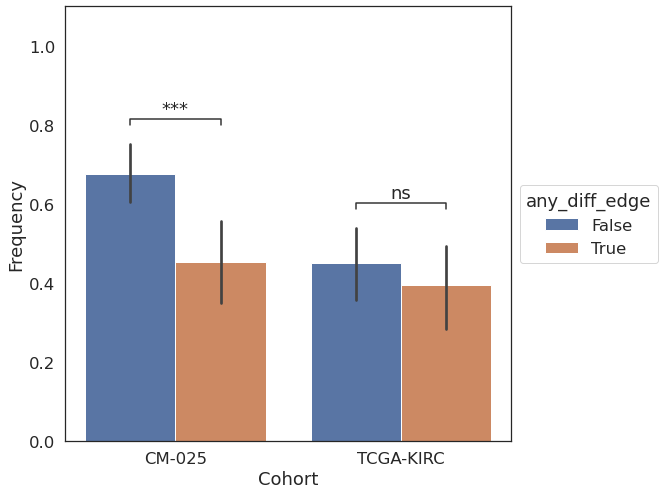

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_False vs. TCGA-KIRC_True: Custom statistical test, P_val:4.601e-01
CM-025_False vs. CM-025_True: Custom statistical test, P_val:2.289e-04


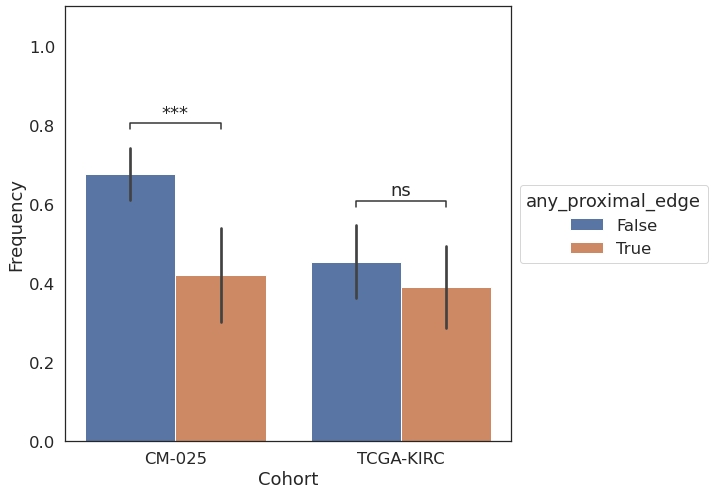

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TCGA-KIRC_False vs. TCGA-KIRC_True: Custom statistical test, P_val:8.411e-01
CM-025_False vs. CM-025_True: Custom statistical test, P_val:1.247e-01


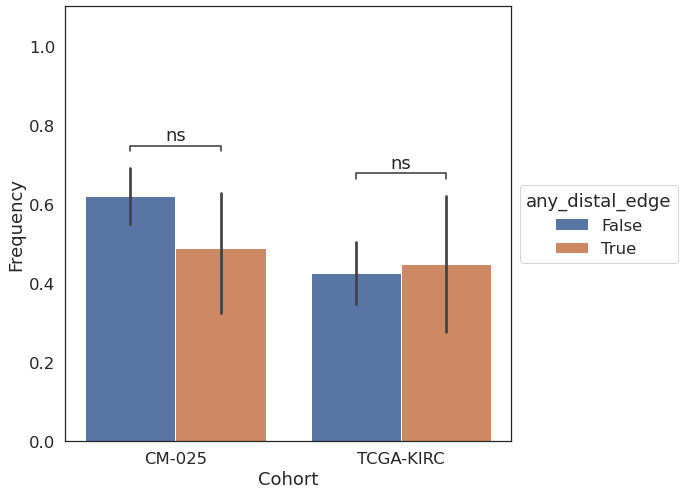

In [32]:
# %%capture
df = filtered_agg_data.loc[filtered_agg_data['9p21.3'].isin(['WT','LOSS'])]
# print('only grabbing Stage IV KIRC + above median GS')
# df = df.loc[(df['cohort'] == 'cm025') | ((df['cohort'] == 'kirc') & (df['stage'] == 'Stage IV') & (df['quantile_bin'] == 'quantile_bin_1'))]
df = df.loc[(df['cohort'] == 'cm025') | ((df['cohort'] == 'kirc') & (df['quantile_bin'] == 'quantile_bin_1'))]

# df = df.loc[(df['cohort'] == 'cm025') | ((df['cohort'] == 'kirc') & (df['stage'] == 'Stage IV'))]

df['Cohort'] = df['cohort'].str.upper()
df['Cohort'] = df['Cohort'].replace({'KIRC':'TCGA-KIRC','CM025':'CM-025', 'PROFILE':'DFCI-PROFILE'})
df['9p21.3_ind'] = df['9p21.3'] == 'LOSS'

x = 'Cohort'
y = 'any_diff_edge'

freq_map = {
    'any_diff_edge':'Proximal or Distal',
    'any_proximal_edge':'Proximal Only',
    'any_distal_edge':'Distal Only'
}

for y in ['9p21.3_ind']:
    for gene in ['any_diff_edge','any_proximal_edge','any_distal_edge']:
        order = [x.upper() for x in ['cm-025','tcga-kirc']]
        hue = gene
        hue_order = None

        conting_upstream = df.set_index([x,hue])[y].reset_index().value_counts([x,hue,y],sort=False)
        manual_fisher_pvals = {cohort:fisher_exact(conting_upstream.loc[cohort].values.reshape((2,2)))[1] for cohort in order}


        df = df.dropna(subset=[x,y,hue])


        g = sns.barplot(x=x, order=order, y=y, hue=hue, data=df,
                     hue_order=hue_order,)
        g.legend(title=gene,loc='center left', bbox_to_anchor=(1., 0.5), ncol=1)

        pairs = [list(product([cohort], df[hue].unique())) for cohort in order]
        pvals = [manual_fisher_pvals[x[0][0]] for x in pairs]

        annotator = Annotator(g, pairs, data=df, x=x, y=y, hue=hue, order=order, hue_order=hue_order)
        annotator.set_pvalues(pvals)
        annotator.annotate()
        plt.ylabel('Frequency')
#         plt.title(f'Grade-Heterogeneity Frequency \n {freq_map[y]}')
        plt.ylim(0,1.1)
        plt.savefig(f'./main_figs/9p213del_frequency_vs_{gene}_status_all_cohorts__cm025_all__kirc_stage4_abovemedianGS.pdf', bbox_inches='tight')
        plt.show()


---
# KM Plots

In [33]:
def construct_km_duo_talk(df, col_groups, stratifier_cols=['ICI','Non-ICI'], strat_col_name='drug_type', min_group_size=0, duration_var='os',
                        leg_x_offset_scale=0.2, leg_y_offset_scale=0.75, leg_y_offset_bias=0.5, at_risk_counts=True):
    event_var = f'{duration_var}_event'
    n_subplots = len(col_groups)
    
    set_rc(int(12*n_subplots),7, font_scale=2)
    sns.set_style('white')
    fig,axes = plt.subplots(1,2*n_subplots, sharex=True, sharey=True)
    
    for rel_idx, cols in enumerate(col_groups):
        for col_idx, strat in enumerate(stratifier_cols):
            temp_sub = df.loc[df[strat_col_name] == strat]

            for labels, subdf in temp_sub.groupby(cols):
                if len(subdf) >= min_group_size:
                    kmf = KaplanMeierFitter()
                    formatted_labels = [label.replace('_',' ').capitalize() for label in labels]
                    if type(labels) == list:
                        combined_label = ' + '.join(formatted_labels) + f'(n={len(subdf)})'
                    else:
                        combined_label = f'{labels} (n={len(subdf)})'

                    kmf.fit(durations=subdf[duration_var], event_observed=subdf[event_var], label=combined_label)
                    g = kmf.plot_survival_function(show_censors=True, ci_show=False, at_risk_counts=at_risk_counts, linewidth=3, ax=axes[col_idx+2*rel_idx]) 
                    move_leg(g, x=(leg_x_offset_scale*col_idx), y=-leg_y_offset_bias-leg_y_offset_scale*col_idx)
                else:
                    print(f'skipping {strat} {labels} !')

                cols_break = " \n ".join(cols)
                axes[col_idx+2*rel_idx].set_title(f'CM-025 {strat.upper()} Arm \n {duration_var.upper()}')
    return fig

In [34]:
def map_qbins_to_label(series, n_bins):
    if n_bins == 3:
        return series.map({'quantile_bin_0':'Lower Grade Score', 'quantile_bin_1':'Intermed. Grade Score', 'quantile_bin_2':'Higher Grade Score'})
    else:
        return series.map({'quantile_bin_0':'Lower Grade Score', 'quantile_bin_1':'Higher Grade Score'})

### KM with At Risk tables

In [35]:
from lifelines.plotting import add_at_risk_counts
from copy import deepcopy

In [36]:
def construct_km_single_mod(df, cols, min_group_size=0, duration_var='os', ci_show=False, ax=None, leg_loc='upper right', rows_to_show=['At risk'], at_risk_labels=False, 
                            timeline_unit='Months', duration_max=150, y_leg_adjust=0.75):
    event_var = duration_var+'_event'
    ylabel_mapper = {'os':'Overall Survival (OS)','pfs':'Progression Free Survival (PFS)', 'pfi':'Progression Free Interval (PFI)'}
    fitter_save = {}
    for labels, subdf in df.groupby(cols):
        if len(subdf) >= min_group_size:
            kmf = KaplanMeierFitter()
            formatted_labels = [label.replace('_',' ').title() for label in labels]
            if type(labels) == list:
                combined_label = ' + '.join(formatted_labels) + f' (n={len(subdf)})'
            if type(labels) == tuple:
                combined_label = ' + '.join(list(formatted_labels)) + f' (n={len(subdf)})'
            else:
                combined_label = f'{labels} (n={len(subdf)})'
            print(labels, combined_label)

            kmf.fit(durations=subdf[duration_var], event_observed=subdf[event_var], label=combined_label)
            fitter_save[labels] = deepcopy(kmf)
            g = kmf.plot_survival_function(show_censors=True, ci_show=ci_show, linewidth=3, ax=ax, loc=slice(0,duration_max)) 
            ylabel = ylabel_mapper[duration_var]
            ax.set_ylabel(ylabel)
            ax.set_xlabel(timeline_unit)
            
            move_leg(g, x=0.0, y=-y_leg_adjust)

#             g.legend(loc=leg_loc)
#             ax.tick_params(which='major', length=7)

            ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        
#             ax.xaxis.set_tick_params(width=5)
#             ax.yaxis.set_tick_params(width=5)

            ax.set_ylim(-0.05,1.05)
            ax.set_xlim(-2.5,duration_max)
    add_at_risk_counts(*fitter_save.values(), ax=ax, ypos=-0.9, rows_to_show=rows_to_show, labels=at_risk_labels)
    
#     plt.tight_layout()
#     return fig
#     return kmf

In [37]:
def construct_duo_wrapper(df, cols, fname_stem, stratifier_cols=['ICI','Non-ICI'], strat_col_name='drug_type', min_group_size=0, duration_var='os', 
                          ci_show=False, ax=None, duration_max=150, rows_to_show=['At risk'], at_risk_labels=False, cohort_prefix=None):
    for col_idx, strat in enumerate(stratifier_cols):
        ax = plt.subplot(111)
        temp_sub = df.loc[df[strat_col_name] == strat]
        g = construct_km_single_mod(temp_sub, cols, duration_var=duration_var, ci_show=ci_show, ax=ax, rows_to_show=rows_to_show, at_risk_labels=at_risk_labels, duration_max=duration_max)
        if cohort_prefix is not None:
            plt.title(f'{cohort_prefix} ({strat})')
        else:
            plt.title(strat)
        plt.savefig(fname_stem + f'_{strat}.pdf', bbox_inches='tight')
        plt.show()


### KIRC: assigned vs continuous grade (QBIN3) [OS]

In [38]:
KM_FONT_SCALE = 1.7
KM_SINGLE_SIZE = 7 
KIRC_DURATION_MAX = 150
CM_DURATION_MAX = 65

selecting kirc
(465, 148)
dropping unusable data (grade seg based)
(431, 148)
dropping entries missing any in ['os', 'pfs']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(429, 148)
grade quantile bins:  [0.0524563  0.33959318 0.58796686 0.95407209]
(429, 149)
dropping low tumor tile count cases
(429, 149)
dropping G1 [keeping unannotated cases]
(419, 149)
dropping metastatic biopsies
(419, 149)
keeping all stages 
(419, 149)
converting bool edge presence labels to string
Higher Grade Score Higher Grade Score (n=142)
Intermed. Grade Score Intermed. Grade Score (n=141)
Lower Grade Score Lower Grade Score (n=134)


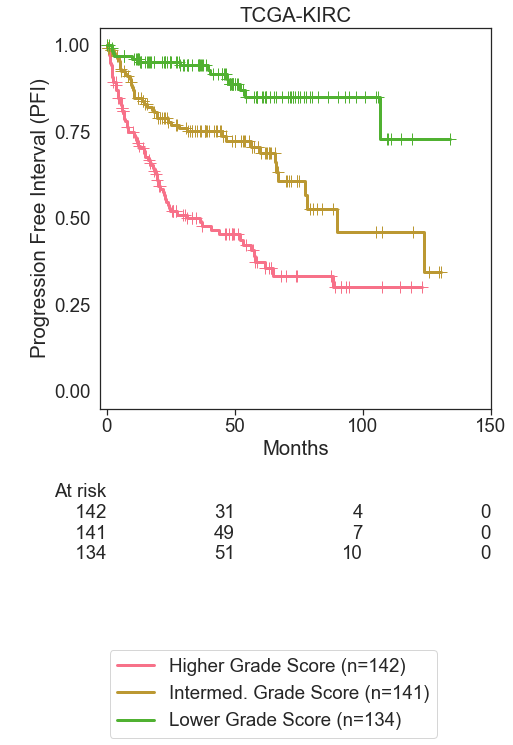

G2 G2 (n=186)
G3 G3 (n=170)
G4 G4 (n=61)


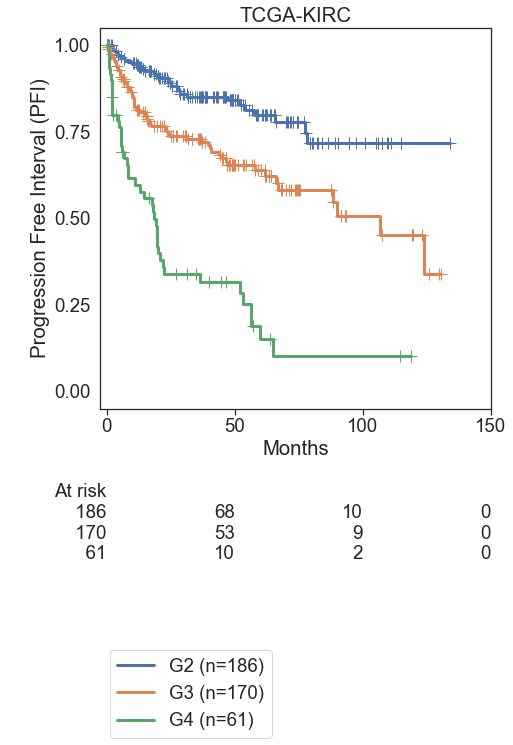

Higher Grade Score Higher Grade Score (n=142)
Intermed. Grade Score Intermed. Grade Score (n=141)
Lower Grade Score Lower Grade Score (n=134)


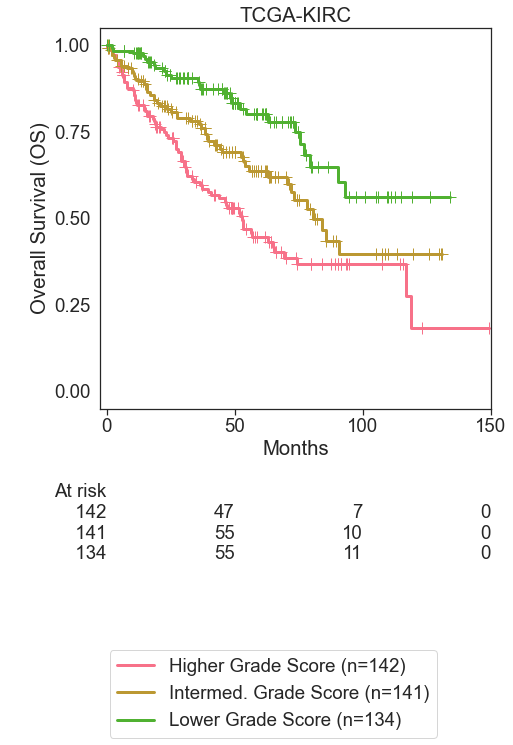

G2 G2 (n=186)
G3 G3 (n=170)
G4 G4 (n=61)


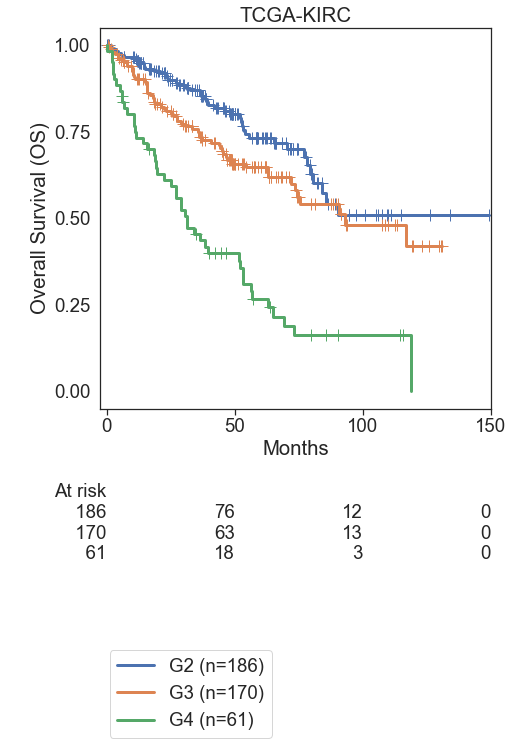

In [39]:
# %%capture
set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

qbins = 3
temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins, mandatory_vars=['os','pfs'])
temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)
temp['pfi'] = temp['pfs']
temp['pfi_event'] = temp['pfs_event']

for duration_var in ['pfi','os']:
    sns.set_palette('husl')
    sns.set_style('white')
    construct_km_single_mod(temp.loc[temp.grade !='GX'], 'quantile_bin', ax=plt.gca(), duration_var=duration_var, duration_max=KIRC_DURATION_MAX, at_risk_labels = ['','','',''])
    plt.title(f'TCGA-KIRC')
    plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
    plt.savefig(f'./main_figs/kirc_{duration_var}_qbin3_grade_only.pdf', bbox_inches='tight')
    plt.show()
    

    set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)
    sns.set_style('white')
    construct_km_single_mod(temp.loc[temp.grade !='GX'], 'grade', ax=plt.gca(), duration_var=duration_var, duration_max=KIRC_DURATION_MAX, at_risk_labels = ['','','',''])
    plt.title(f'TCGA-KIRC')
    plt.savefig(f'./main_figs/kirc_{duration_var}_assigned_grade_only.pdf', bbox_inches='tight')
    plt.show()

### KIRC: collapsing G2+3 + Any Diff Edge

selecting kirc
(465, 148)
dropping unusable data (grade seg based)
(431, 148)
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(431, 148)
grade quantile bins:  [0.0524563  0.34008044 0.5945049  0.95407209]
(431, 149)
dropping low tumor tile count cases
(431, 149)
dropping G1 [keeping unannotated cases]
(421, 149)
dropping metastatic biopsies
(421, 149)
keeping all stages 
(421, 149)
converting bool edge presence labels to string
Heterogeneous Heterogeneous (n=151)
Homogeneous Homogeneous (n=207)


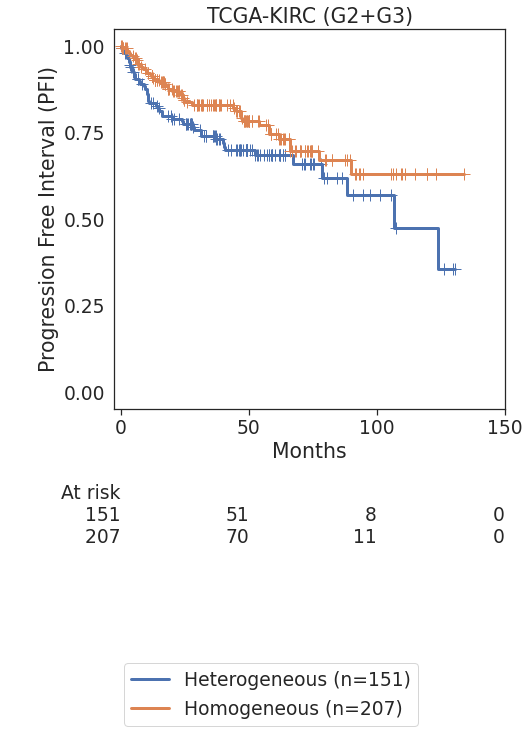

Heterogeneous Heterogeneous (n=19)
Homogeneous Homogeneous (n=42)


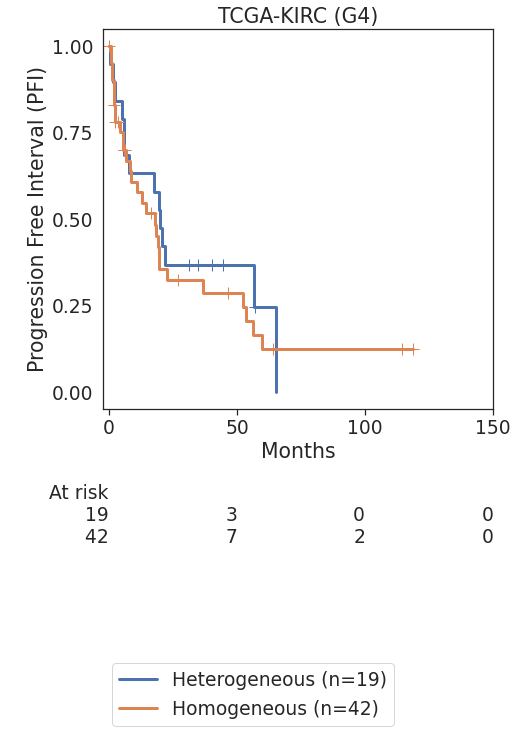

Heterogeneous Heterogeneous (n=151)
Homogeneous Homogeneous (n=207)


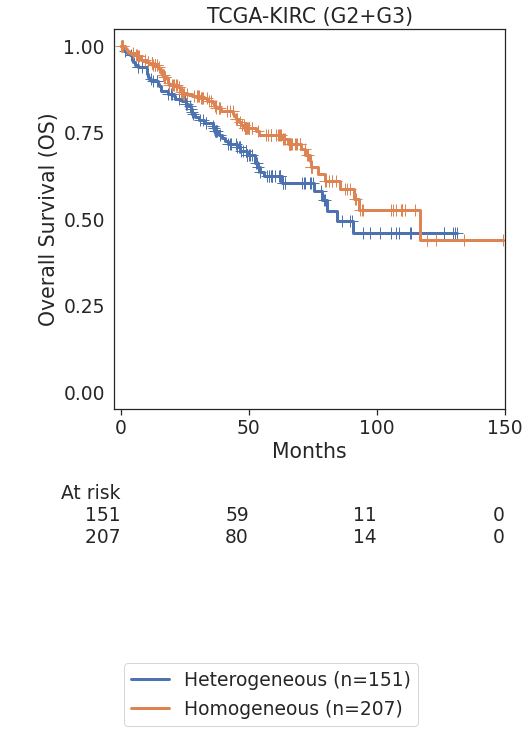

Heterogeneous Heterogeneous (n=20)
Homogeneous Homogeneous (n=43)


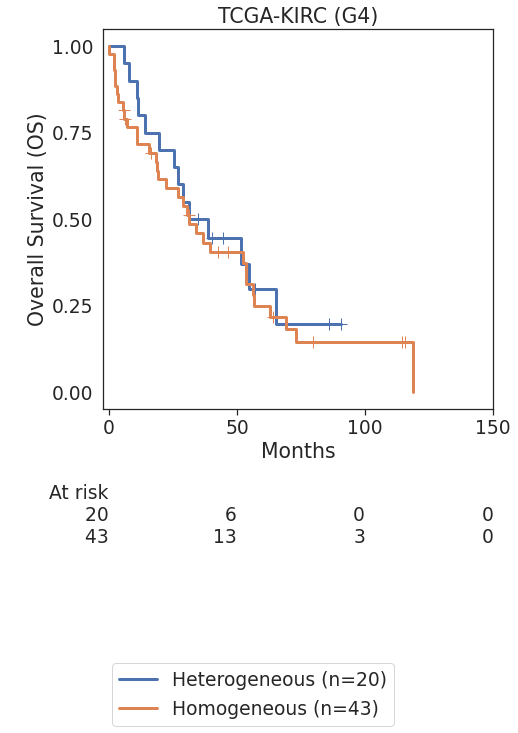

In [40]:
# %%capture
set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

col_b = 'any_diff_edge'
qbins = 3

temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)
col_a = 'grade_collapsed'
temp['grade_collapsed'] = (temp['grade'] == 'G4').map({False:'G2+G3',True:'G4'})

temp['Grade Heterogeneity'] = temp['any_diff_edge']
temp['Grade Heterogeneity'] = temp['Grade Heterogeneity'].map({'Low/Hi Presence':'Heterogeneous', 'No Mixed Foci Presence':'Homogeneous'})
temp['pfi'] = temp['pfs']
temp['pfi_event'] = temp['pfs_event']

for col in ['Grade Heterogeneity']:
    for duration_var in ['pfi','os']:
        
        construct_duo_wrapper(temp.dropna(subset=[duration_var]), [col],f'./main_figs/[split_km]kirc_{duration_var}_collapsed_assigned_grade_vs_rag_{col}',
                              ['G2+G3','G4'],  'grade_collapsed', duration_var=duration_var, ci_show=False, ax=plt.gca(), rows_to_show=['At risk'], duration_max=KIRC_DURATION_MAX, 
                              at_risk_labels = ['','','',''], cohort_prefix='TCGA-KIRC')
        
#         fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
#         for rel_idx, qbin in enumerate(['G2+G3','G4']):
#             construct_km_single_mod(temp.loc[temp[col_a] == qbin].dropna(subset=[duration_var]), col, ax=axes[rel_idx], duration_var=duration_var, leg_loc='lower left')
#             axes[rel_idx].set_title(f'TCGA KIRC, {duration_var.upper()} \n {qbin}')
#         plt.savefig(f'./main_figs/kirc_{duration_var}_collapsed_assigned_grade_vs_rag_{col}.pdf')
    
        plt.show()


### KIRC: collapsing Q(1/3) & Q(2/3) + Any Diff Edge

selecting kirc
(465, 148)
dropping unusable data (grade seg based)
(431, 148)
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(431, 148)
grade quantile bins:  [0.0524563  0.34008044 0.5945049  0.95407209]
(431, 149)
dropping low tumor tile count cases
(431, 149)
dropping G1 [keeping unannotated cases]
(421, 149)
dropping metastatic biopsies
(421, 149)
keeping all stages 
(421, 149)
converting bool edge presence labels to string
Heterogeneous Heterogeneous (n=126)
Homogeneous Homogeneous (n=152)


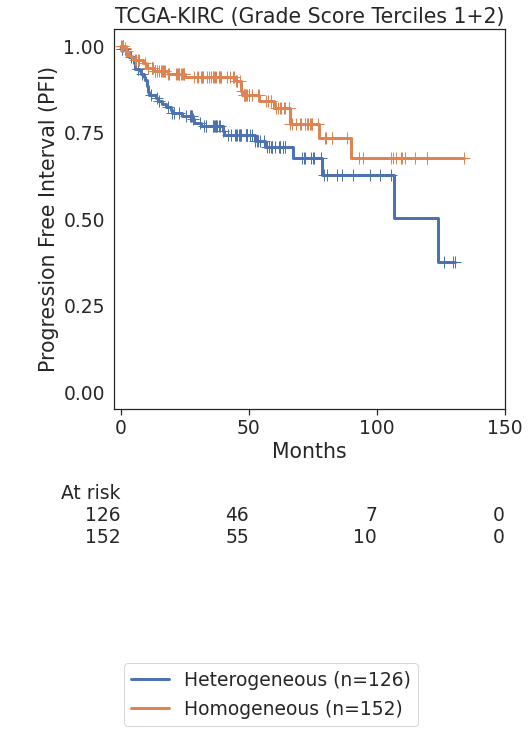

Heterogeneous Heterogeneous (n=44)
Homogeneous Homogeneous (n=97)


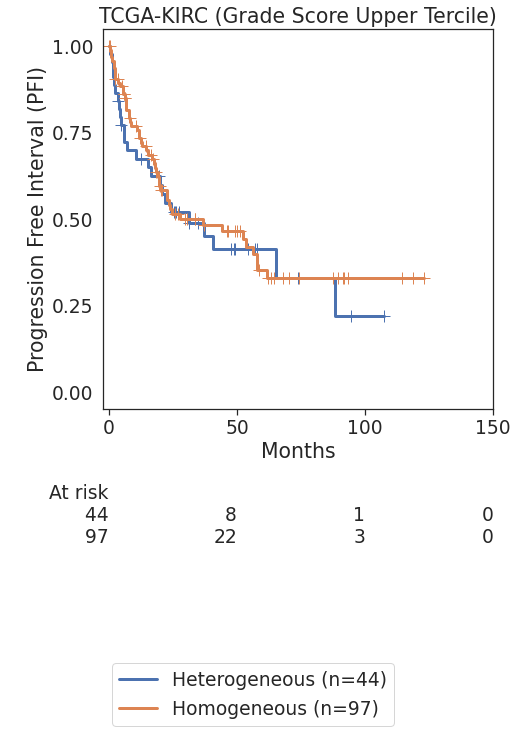

Heterogeneous Heterogeneous (n=126)
Homogeneous Homogeneous (n=152)


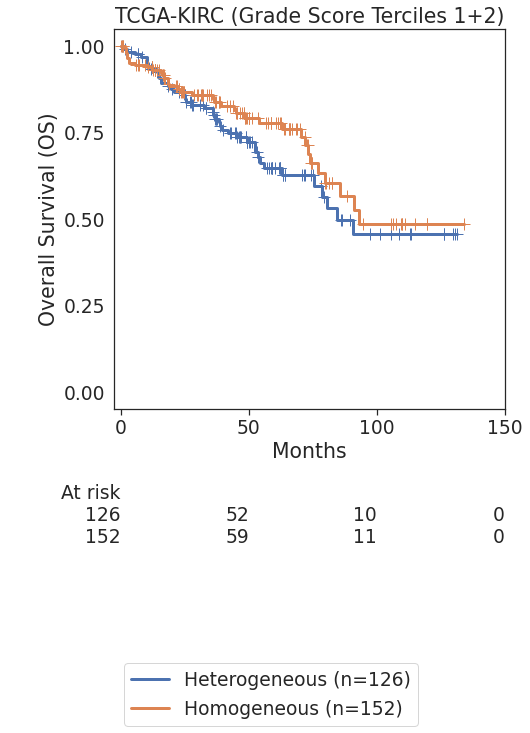

Heterogeneous Heterogeneous (n=45)
Homogeneous Homogeneous (n=98)


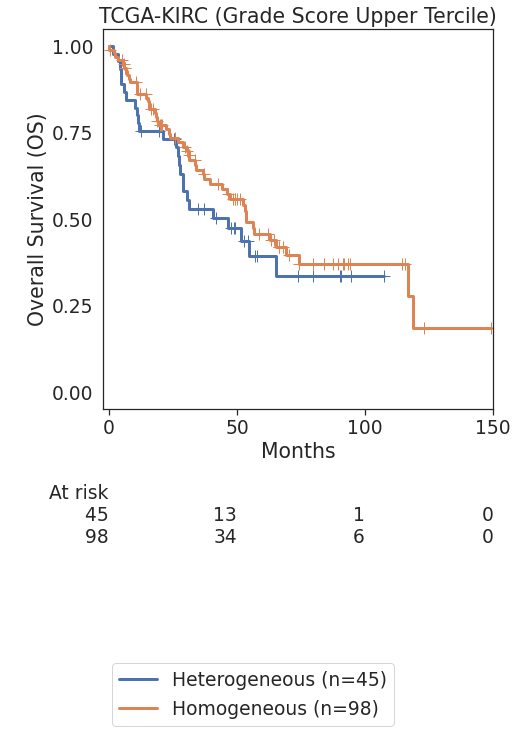

In [41]:
# %%capture
set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

col_b = 'any_diff_edge'
qbins = 3

temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)
temp['quantile_bin'] = (temp['quantile_bin'] == 'Higher Grade Score').map({False:'Grade Score Terciles 1+2',True:'Grade Score Upper Tercile'})
col_a = 'quantile_bin'

temp['Grade Heterogeneity'] = temp['any_diff_edge']
temp['Grade Heterogeneity'] = temp['Grade Heterogeneity'].map({'Low/Hi Presence':'Heterogeneous', 'No Mixed Foci Presence':'Homogeneous'})

temp['pfi'] = temp['pfs']
temp['pfi_event'] = temp['pfs_event']

for col in ['Grade Heterogeneity',]:
    for duration_var in ['pfi','os']:
        
        construct_duo_wrapper(temp.dropna(subset=[duration_var]), [col], f'./main_figs/[split_km]kirc_{duration_var}_collapsed_qbin3_vs_rag_{col}',
                             ['Grade Score Terciles 1+2','Grade Score Upper Tercile'], 'quantile_bin', duration_var=duration_var, ci_show=False, ax=plt.gca(), rows_to_show=['At risk'], duration_max=KIRC_DURATION_MAX, 
                              at_risk_labels = ['','','',''], cohort_prefix='TCGA-KIRC')
        
#         fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
#         for rel_idx, qbin in enumerate(['Lower Q(2/3)','Upper Tercile']):
#             construct_km_single(temp.loc[temp[col_a] == qbin].dropna(subset=[duration_var]), col, ax=axes[rel_idx], duration_var=duration_var, leg_loc='lower left')
#             construct_duo_wrapper(temp.loc[temp[col_a] == qbin].dropna(subset=[duration_var]), col, ax=axes[rel_idx], duration_var=duration_var,)
#             axes[rel_idx].set_title(f'TCGA KIRC, {duration_var.upper()} \n {qbin}')
# #         plt.savefig(f'./main_figs/kirc_{duration_var}_collapsed_qbin3_vs_rag_{col}.pdf')
    
        plt.show()


### Don't combine G2/3 

selecting kirc
(465, 148)
dropping unusable data (grade seg based)
(431, 148)
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(431, 148)
grade quantile bins:  [0.0524563  0.34008044 0.5945049  0.95407209]
(431, 149)
dropping low tumor tile count cases
(431, 149)
dropping G1 [keeping unannotated cases]
(421, 149)
dropping metastatic biopsies
(421, 149)
keeping all stages 
(421, 149)
converting bool edge presence labels to string
Heterogeneous Heterogeneous (n=67)
Homogeneous Homogeneous (n=119)


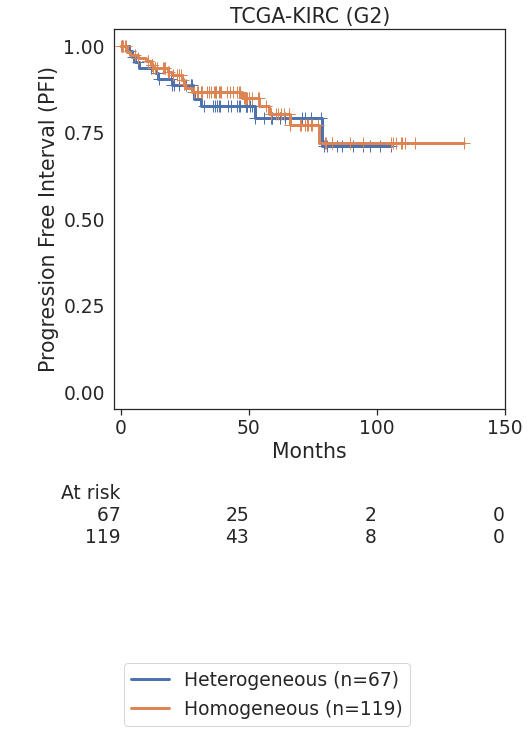

Heterogeneous Heterogeneous (n=84)
Homogeneous Homogeneous (n=86)


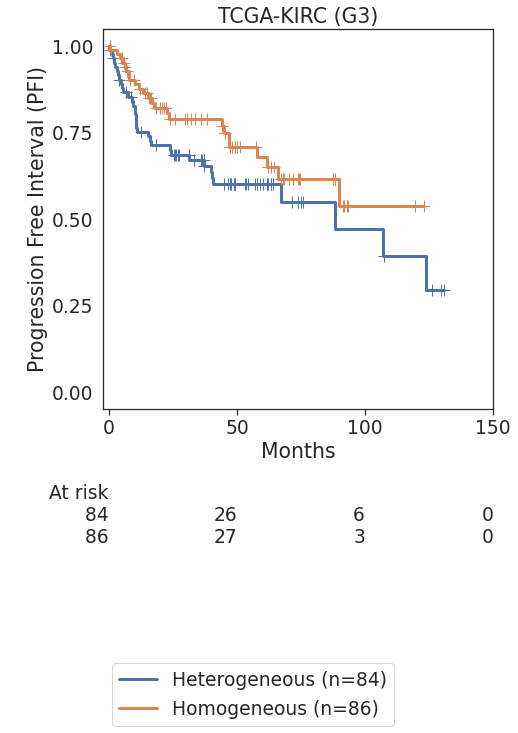

Heterogeneous Heterogeneous (n=19)
Homogeneous Homogeneous (n=42)


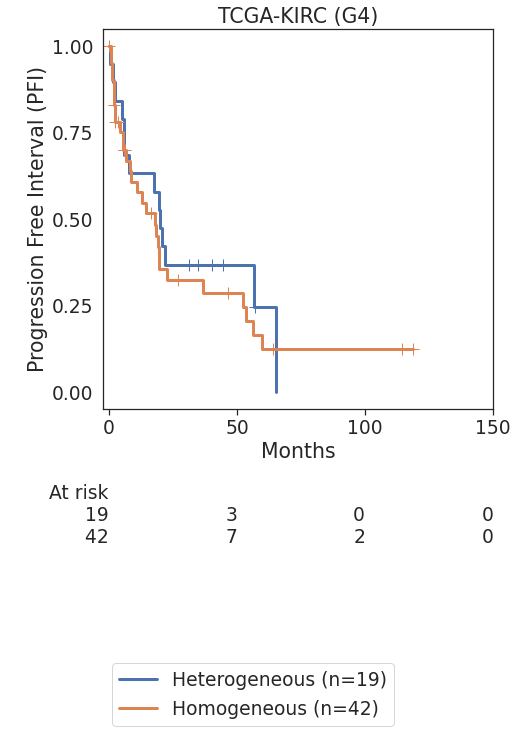

Heterogeneous Heterogeneous (n=67)
Homogeneous Homogeneous (n=119)


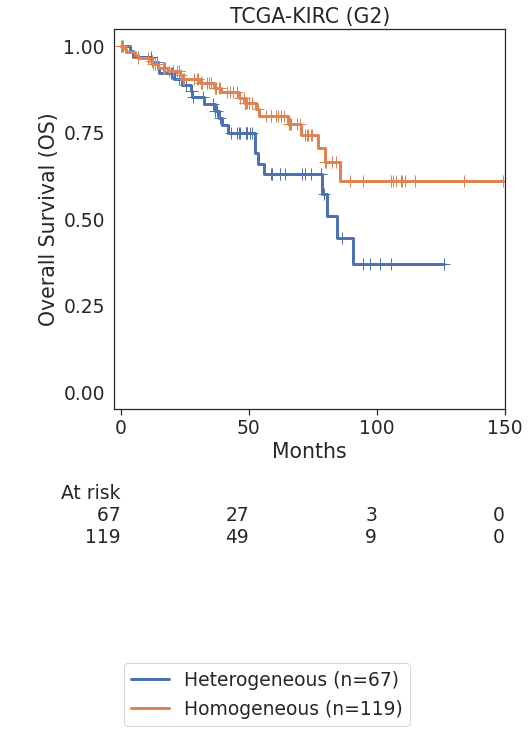

Heterogeneous Heterogeneous (n=84)
Homogeneous Homogeneous (n=86)


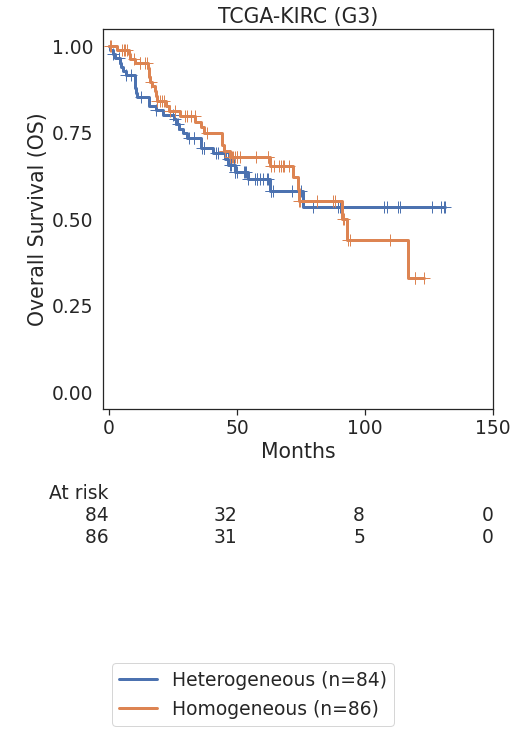

Heterogeneous Heterogeneous (n=20)
Homogeneous Homogeneous (n=43)


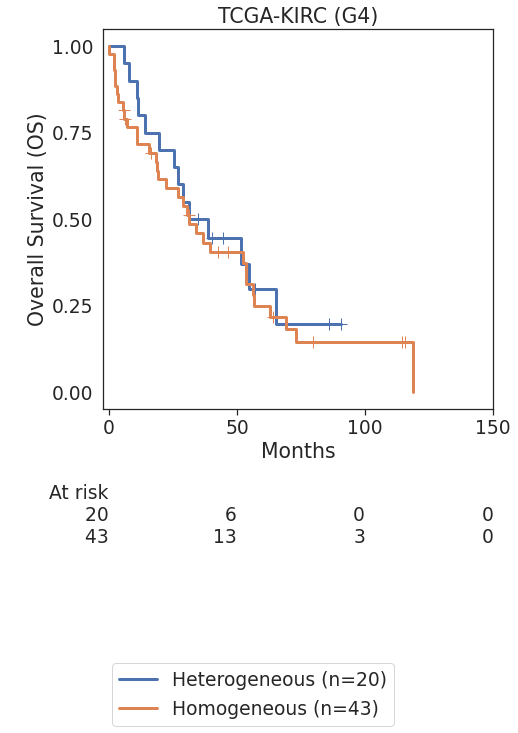

In [43]:
# %%capture
set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

col_b = 'any_diff_edge'
qbins = 3

temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)
temp['quantile_bin'] = (temp['quantile_bin'] == 'Higher Grade Score').map({False:'Grade Score Terciles 1+2',True:'Grade Score Upper Tercile'})
col_a = 'quantile_bin'

temp['Grade Heterogeneity'] = temp['any_diff_edge']
temp['Grade Heterogeneity'] = temp['Grade Heterogeneity'].map({'Low/Hi Presence':'Heterogeneous', 'No Mixed Foci Presence':'Homogeneous'})

temp['pfi'] = temp['pfs']
temp['pfi_event'] = temp['pfs_event']

for col in ['Grade Heterogeneity',]:
    for duration_var in ['pfi','os']:
        fname = f'./main_figs/[split_km]kirc_{duration_var}_pathgrade_vs_rag_{col}'
        construct_duo_wrapper(temp.dropna(subset=[duration_var]), [col], fname,
                             ['G2','G3','G4'], 'grade', duration_var=duration_var, ci_show=False, ax=plt.gca(), rows_to_show=['At risk'], duration_max=KIRC_DURATION_MAX, 
                              at_risk_labels = ['','','',''], cohort_prefix='TCGA-KIRC')
        
        plt.show()


selecting kirc
(465, 148)
dropping unusable data (grade seg based)
(431, 148)
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(431, 148)
grade quantile bins:  [0.0524563  0.34008044 0.5945049  0.95407209]
(431, 149)
dropping low tumor tile count cases
(431, 149)
dropping G1 [keeping unannotated cases]
(421, 149)
dropping metastatic biopsies
(421, 149)
keeping all stages 
(421, 149)
converting bool edge presence labels to string
Heterogeneous Heterogeneous (n=46)
Homogeneous Homogeneous (n=91)


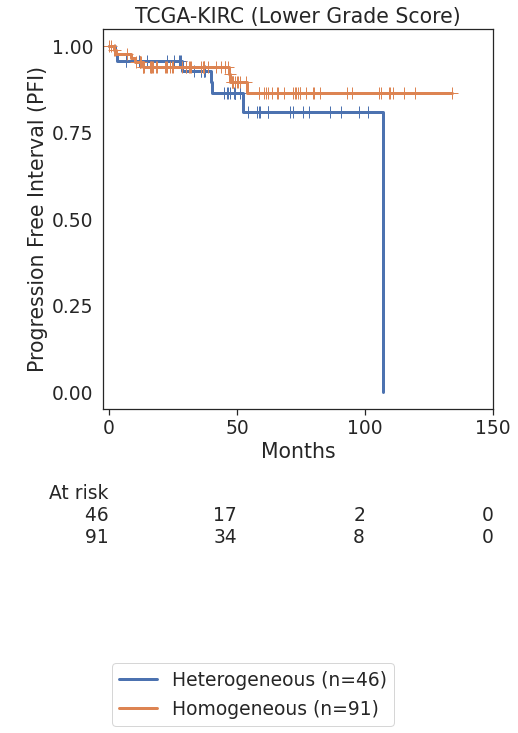

Heterogeneous Heterogeneous (n=80)
Homogeneous Homogeneous (n=61)


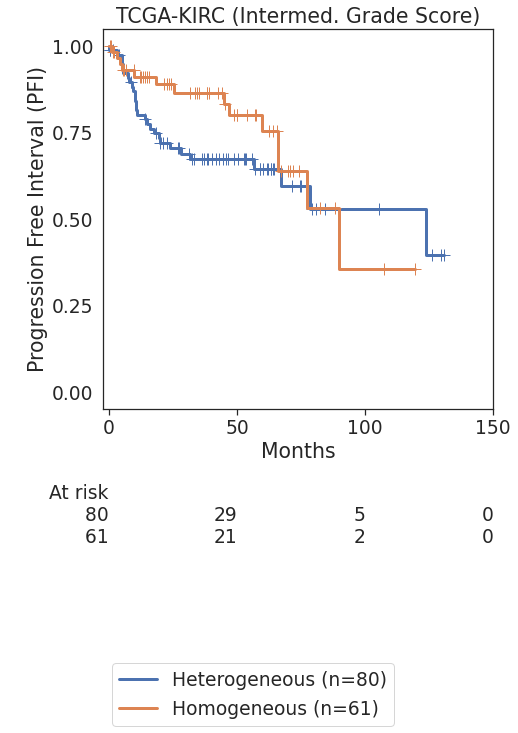

Heterogeneous Heterogeneous (n=44)
Homogeneous Homogeneous (n=97)


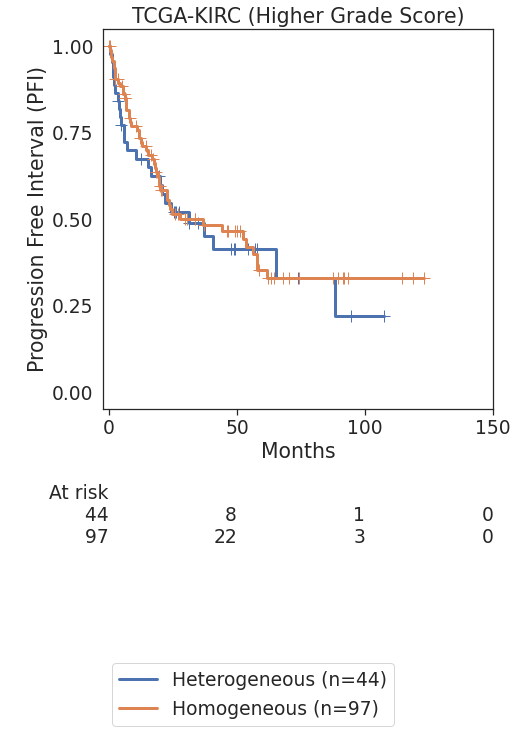

Heterogeneous Heterogeneous (n=46)
Homogeneous Homogeneous (n=91)


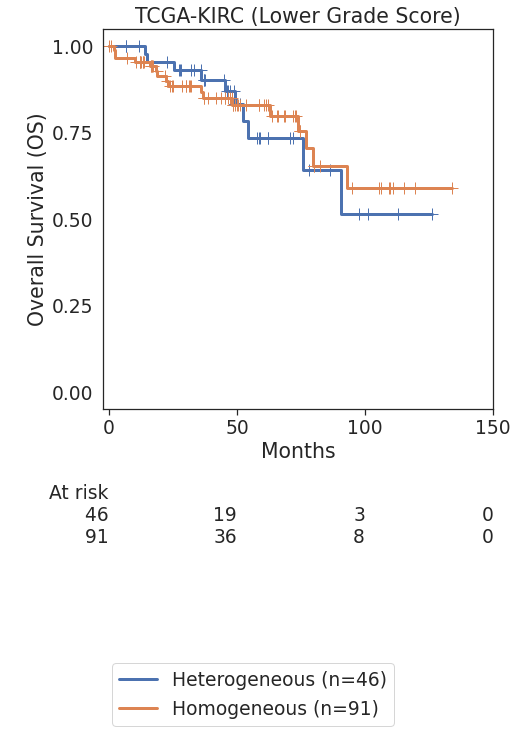

Heterogeneous Heterogeneous (n=80)
Homogeneous Homogeneous (n=61)


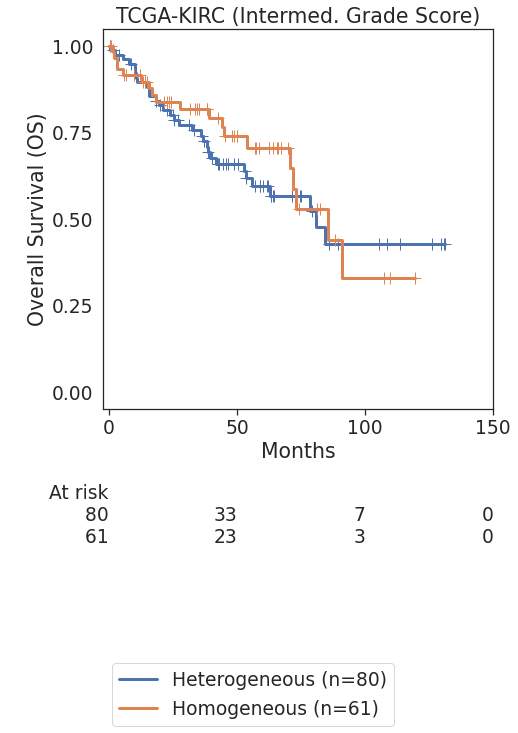

Heterogeneous Heterogeneous (n=45)
Homogeneous Homogeneous (n=98)


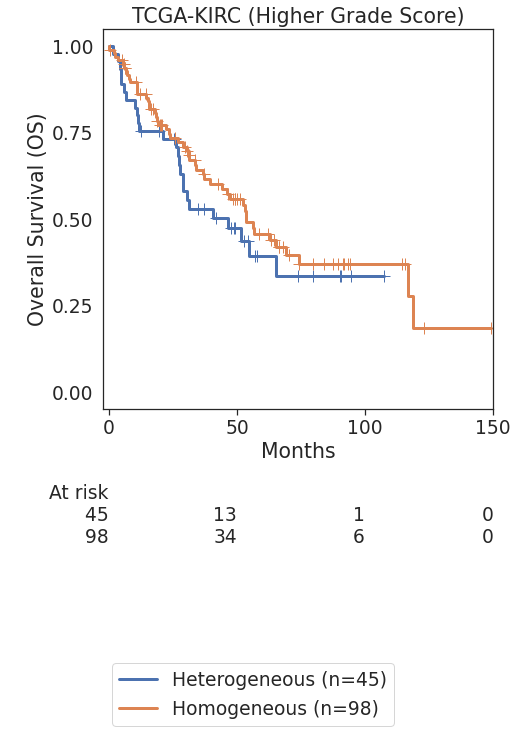

In [44]:
# %%capture
set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

col_b = 'any_diff_edge'
qbins = 3

temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)
# temp['quantile_bin'] = (temp['quantile_bin'] == 'Higher Grade Score').map({False:'Grade Score Terciles 1+2',True:'Grade Score Upper Tercile'})
col_a = 'quantile_bin'

temp['Grade Heterogeneity'] = temp['any_diff_edge']
temp['Grade Heterogeneity'] = temp['Grade Heterogeneity'].map({'Low/Hi Presence':'Heterogeneous', 'No Mixed Foci Presence':'Homogeneous'})

temp['pfi'] = temp['pfs']
temp['pfi_event'] = temp['pfs_event']

for col in ['Grade Heterogeneity',]:
    for duration_var in ['pfi','os']:
        fname = f'./main_figs/[split_km]kirc_{duration_var}_qbin3_vs_rag_{col}'
        construct_duo_wrapper(temp.dropna(subset=[duration_var]), [col], fname,
                             ['Lower Grade Score', 'Intermed. Grade Score', 'Higher Grade Score'], 'quantile_bin', duration_var=duration_var, ci_show=False, ax=plt.gca(), rows_to_show=['At risk'], duration_max=KIRC_DURATION_MAX, 
                              at_risk_labels = ['','','',''], cohort_prefix='TCGA-KIRC')
        plt.show()


### CM025

In [45]:
%%capture
drug_type = 'any'
outcome_type = 'benefit'
duration_var = 'os'
mandatory_vars = []
drop_g1 = True
drop_met_site = True
risk_type = 'MSKCC'
use_risk_group_info = False
til_only_cases = False
gene = None
drop_intermed_group = False
qbins = 2
high_grade_filter = False

temp = prepare_cm025_subset(feature_subset, anno=anno, drug_type=drug_type, mandatory_vars=mandatory_vars,
                            duration_var=duration_var, outcome_type=outcome_type, til_only_cases=til_only_cases, 
                            risk_type=risk_type, drop_met_site=drop_met_site, qbins=qbins,
                            gene=gene, drop_intermed_group=drop_intermed_group,
                           high_grade_filter=high_grade_filter)

if qbins == 3:
    temp['quantile_bin'] = temp['quantile_bin'].map({'quantile_bin_0':'Lower Grade Score', 'quantile_bin_1':'Intermed. Grade Score', 'quantile_bin_2':'Higher Grade Score'})
elif qbins == 2:
    temp['quantile_bin'] = temp['quantile_bin'].map({'quantile_bin_0':'Lower Grade Score', 'quantile_bin_1':'Higher Grade Score'})
    
temp['single_node_case'] = temp['single_node_case'].map({False:'Multifocal', True:'Single Focal'})

### CM025 Marginals [any_diff_edge] [no HG filter]

Heterogeneous Heterogeneous (n=67)
Homogeneous Homogeneous (n=152)


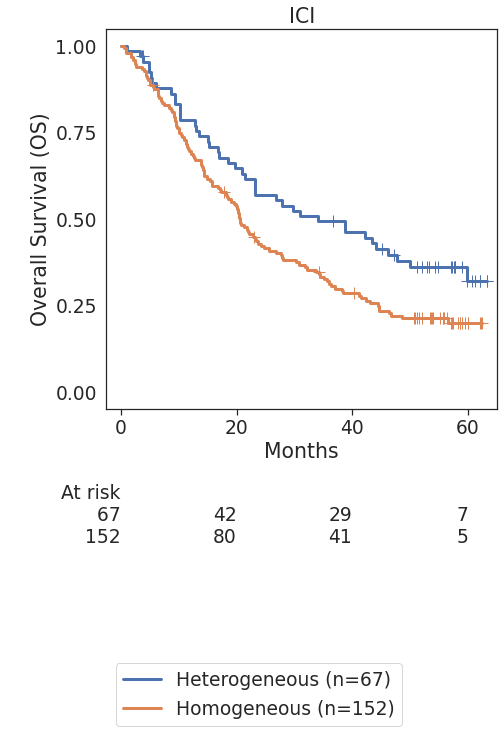

Heterogeneous Heterogeneous (n=83)
Homogeneous Homogeneous (n=137)


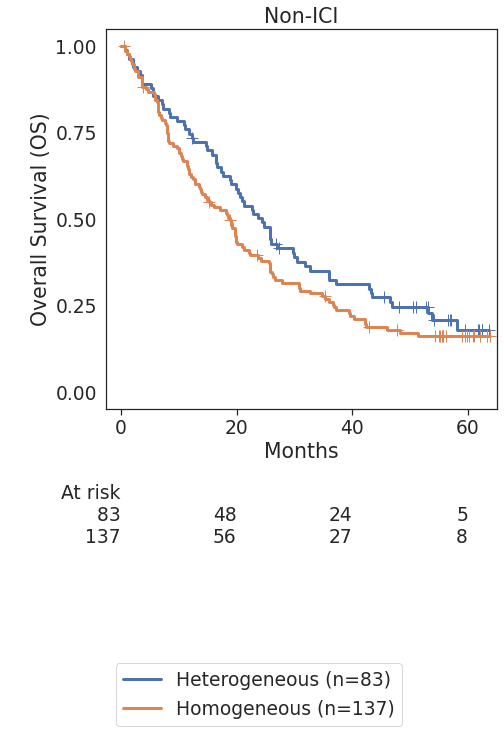

Heterogeneous Heterogeneous (n=67)
Homogeneous Homogeneous (n=152)


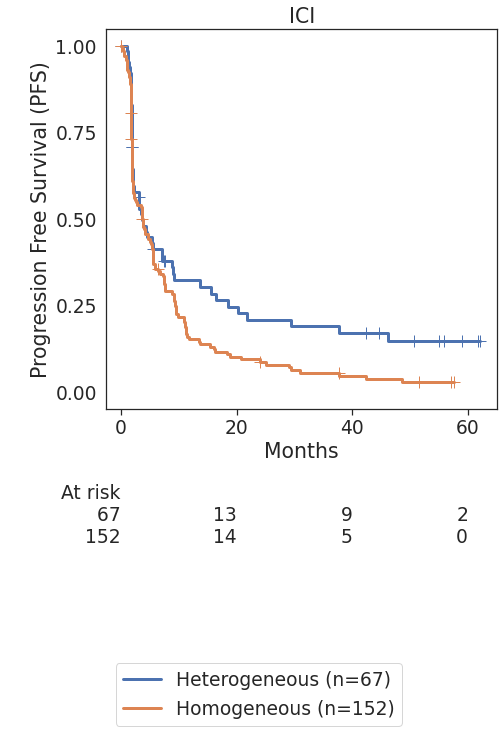

Heterogeneous Heterogeneous (n=83)
Homogeneous Homogeneous (n=137)


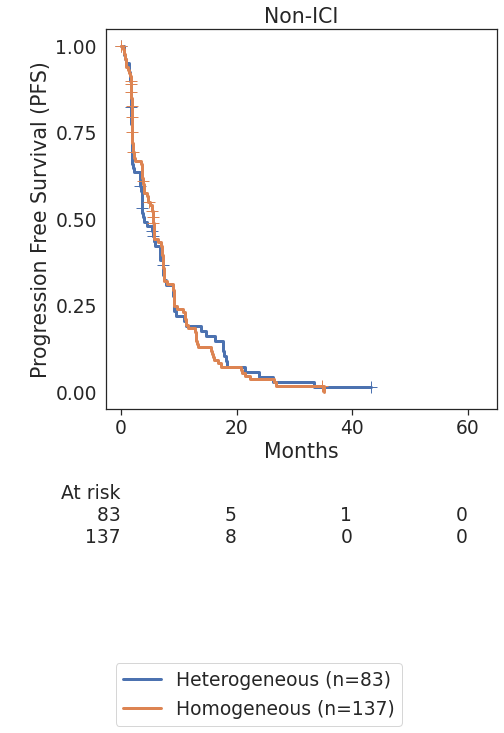

In [46]:
# %%capture
set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

temp['Grade Heterogeneity'] = temp['any_diff_edge']
temp['Grade Heterogeneity'] = temp['Grade Heterogeneity'].map({'Low/Hi Presence':'Heterogeneous', 'No Mixed Foci Presence':'Homogeneous'})

temp['Global Infiltration'] = temp['global_infiltration_bin']
temp['Global Infiltration'] = temp['Global Infiltration'].map({'high_hg_global_infiltration':'High Infiltration', 'low_hg_global_infiltration':'Low Infiltration'})

col = 'Grade Heterogeneity'

for duration_var in ['os','pfs']:
    construct_duo_wrapper(temp.dropna(subset=[duration_var]), [col], f'./main_figs/[split_km]cm025_{col}_{duration_var}',
                         ['ICI','Non-ICI'], 'drug_type', duration_var=duration_var, ci_show=False, ax=plt.gca(), rows_to_show=['At risk'], duration_max=CM_DURATION_MAX, at_risk_labels = ['','','',''] )

### CM025 Marginals [quantile_bin 2] [no HG filter]

Lower Grade Score Lower Grade Score (n=100)
Higher Grade Score Higher Grade Score (n=119)


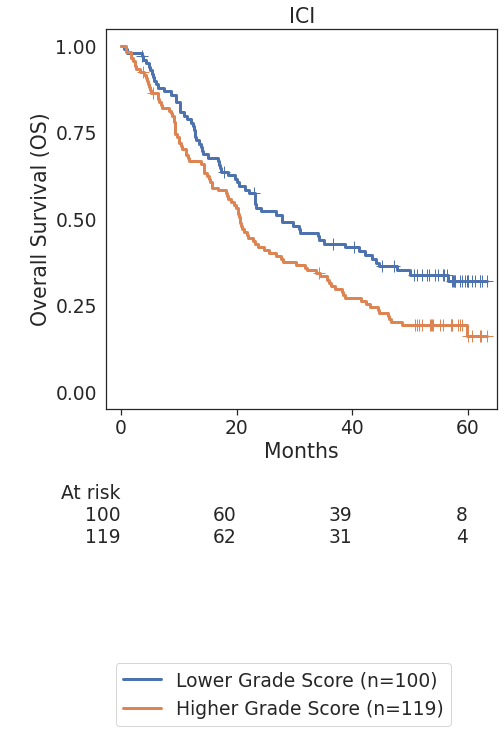

Lower Grade Score Lower Grade Score (n=114)
Higher Grade Score Higher Grade Score (n=106)


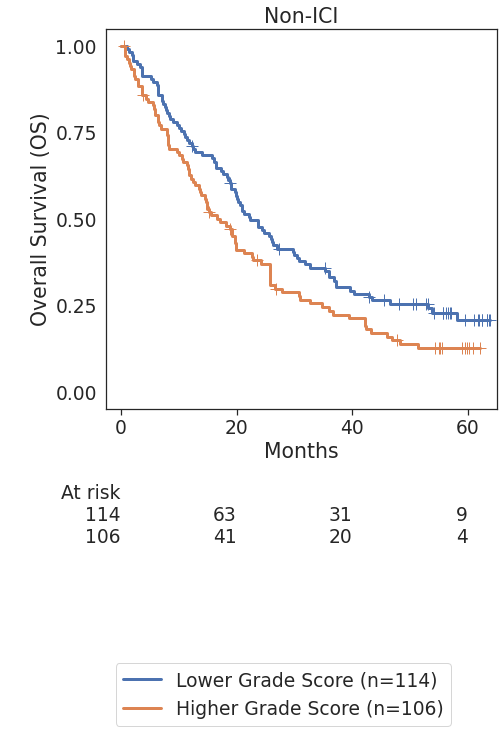

Lower Grade Score Lower Grade Score (n=100)
Higher Grade Score Higher Grade Score (n=119)


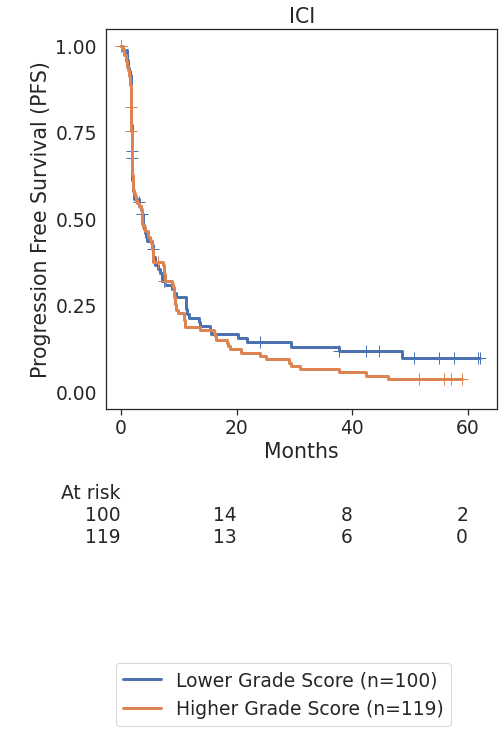

Lower Grade Score Lower Grade Score (n=114)
Higher Grade Score Higher Grade Score (n=106)


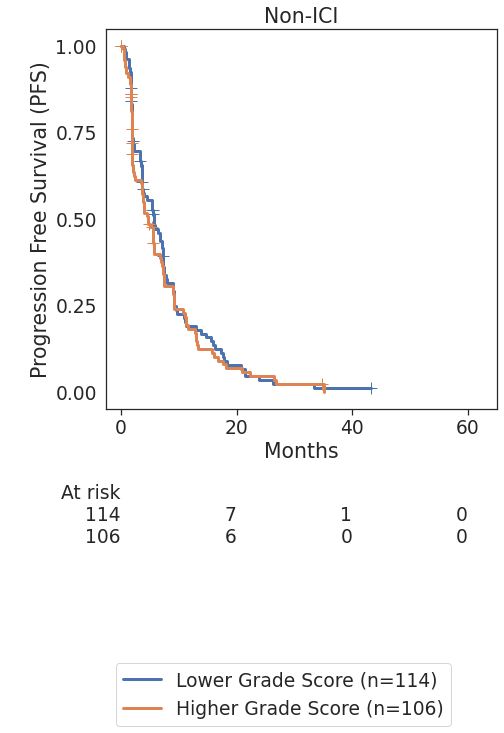

In [47]:
# %%capture
set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

col = 'quantile_bin'

for duration_var in ['os','pfs']:
    construct_duo_wrapper(temp.dropna(subset=[duration_var]), [col],f'./supp_figs/[split_km]cm025_qbin2_{duration_var}',
                         ['ICI','Non-ICI'], 'drug_type', duration_var=duration_var, ci_show=False, ax=plt.gca(), rows_to_show=['At risk'], duration_max=CM_DURATION_MAX, at_risk_labels = ['','','',''])

### CM025 any_diff_edge vs global QBIN2

('Heterogeneous', 'Lower Grade Score') Heterogeneous + Lower Grade Score (n=51)
('Heterogeneous', 'Higher Grade Score') Heterogeneous + Higher Grade Score (n=16)
('Homogeneous', 'Lower Grade Score') Homogeneous + Lower Grade Score (n=49)
('Homogeneous', 'Higher Grade Score') Homogeneous + Higher Grade Score (n=103)


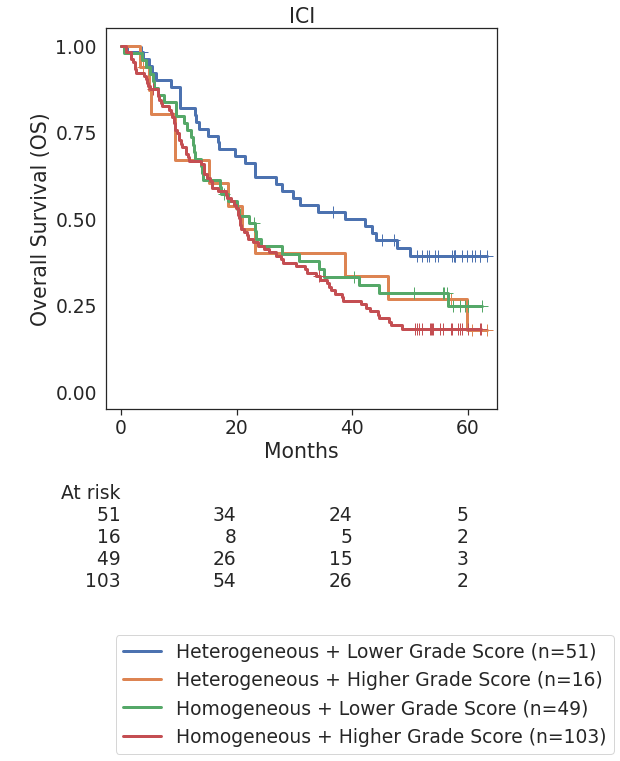

('Heterogeneous', 'Lower Grade Score') Heterogeneous + Lower Grade Score (n=68)
('Heterogeneous', 'Higher Grade Score') Heterogeneous + Higher Grade Score (n=15)
('Homogeneous', 'Lower Grade Score') Homogeneous + Lower Grade Score (n=46)
('Homogeneous', 'Higher Grade Score') Homogeneous + Higher Grade Score (n=91)


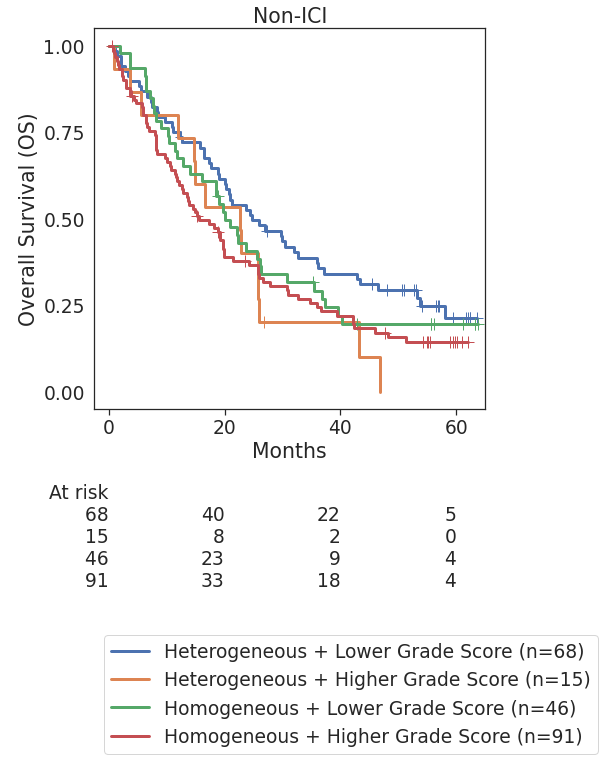

('Heterogeneous', 'Lower Grade Score') Heterogeneous + Lower Grade Score (n=51)
('Heterogeneous', 'Higher Grade Score') Heterogeneous + Higher Grade Score (n=16)
('Homogeneous', 'Lower Grade Score') Homogeneous + Lower Grade Score (n=49)
('Homogeneous', 'Higher Grade Score') Homogeneous + Higher Grade Score (n=103)


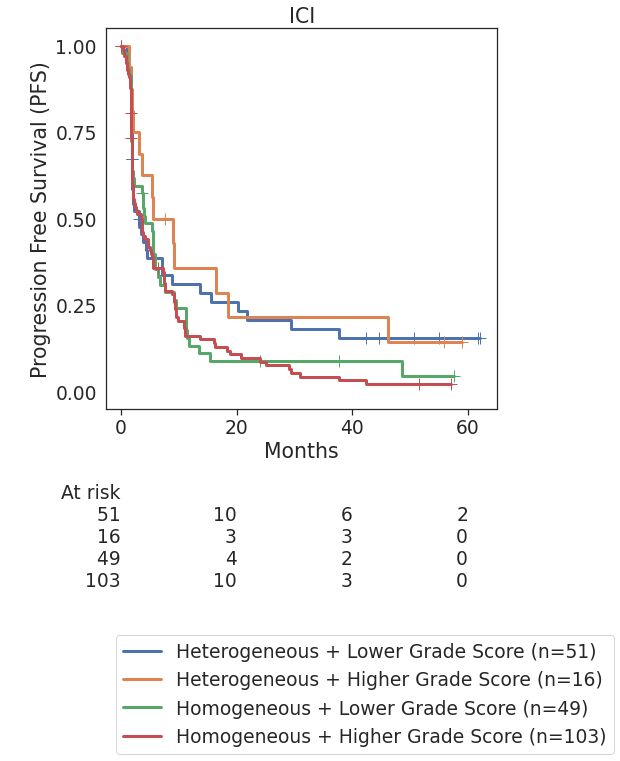

('Heterogeneous', 'Lower Grade Score') Heterogeneous + Lower Grade Score (n=68)
('Heterogeneous', 'Higher Grade Score') Heterogeneous + Higher Grade Score (n=15)
('Homogeneous', 'Lower Grade Score') Homogeneous + Lower Grade Score (n=46)
('Homogeneous', 'Higher Grade Score') Homogeneous + Higher Grade Score (n=91)


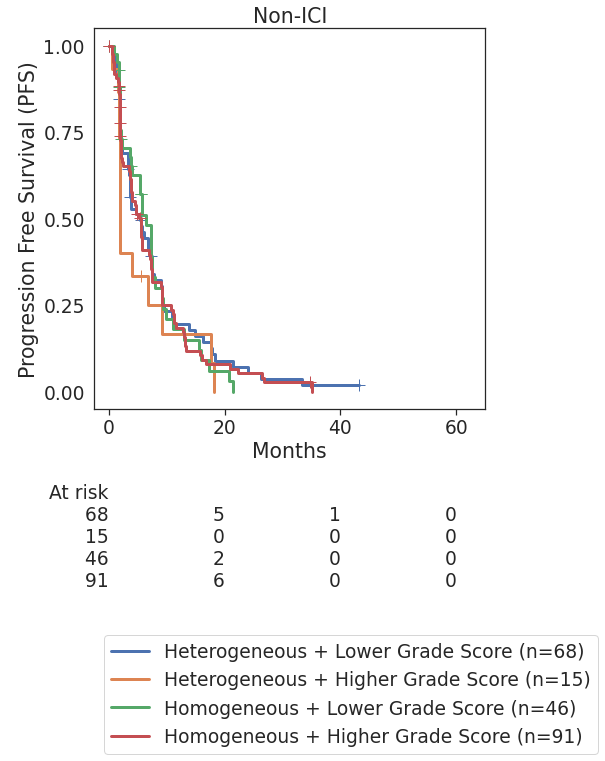

In [48]:
# %%capture
set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

cols = ['Grade Heterogeneity','quantile_bin']
for duration_var in ['os','pfs']:
    construct_duo_wrapper(temp.dropna(subset=[duration_var]), cols, f'./main_figs/[split_km]cm025_any_diff_edge_globalqbin2_{duration_var}',
                         ['ICI','Non-ICI'], 'drug_type', duration_var=duration_var, ci_show=False, ax=plt.gca(), rows_to_show=['At risk'], duration_max=CM_DURATION_MAX, at_risk_labels = ['','','',''])

### CM025 any_diff_edge vs relative QBIN2

('Heterogeneous', 'Higher (Relative)') Heterogeneous + Higher (Relative) (n=32)
('Heterogeneous', 'Lower (Relative)') Heterogeneous + Lower (Relative) (n=35)
('Homogeneous', 'Higher (Relative)') Homogeneous + Higher (Relative) (n=78)
('Homogeneous', 'Lower (Relative)') Homogeneous + Lower (Relative) (n=74)


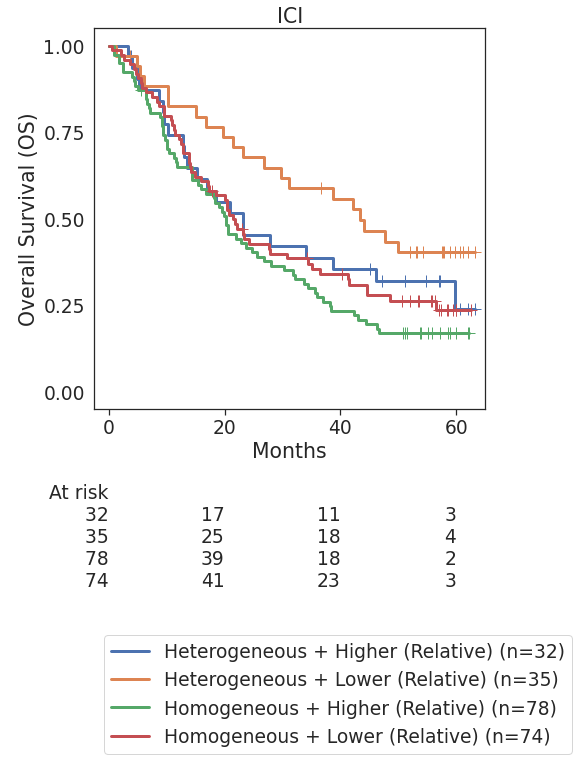

('Heterogeneous', 'Higher (Relative)') Heterogeneous + Higher (Relative) (n=43)
('Heterogeneous', 'Lower (Relative)') Heterogeneous + Lower (Relative) (n=40)
('Homogeneous', 'Higher (Relative)') Homogeneous + Higher (Relative) (n=66)
('Homogeneous', 'Lower (Relative)') Homogeneous + Lower (Relative) (n=71)


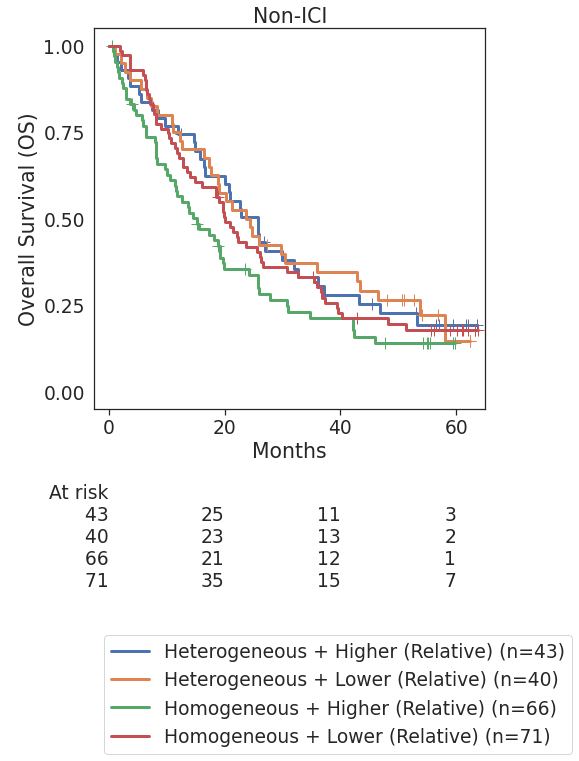

('Heterogeneous', 'Higher (Relative)') Heterogeneous + Higher (Relative) (n=32)
('Heterogeneous', 'Lower (Relative)') Heterogeneous + Lower (Relative) (n=35)
('Homogeneous', 'Higher (Relative)') Homogeneous + Higher (Relative) (n=78)
('Homogeneous', 'Lower (Relative)') Homogeneous + Lower (Relative) (n=74)


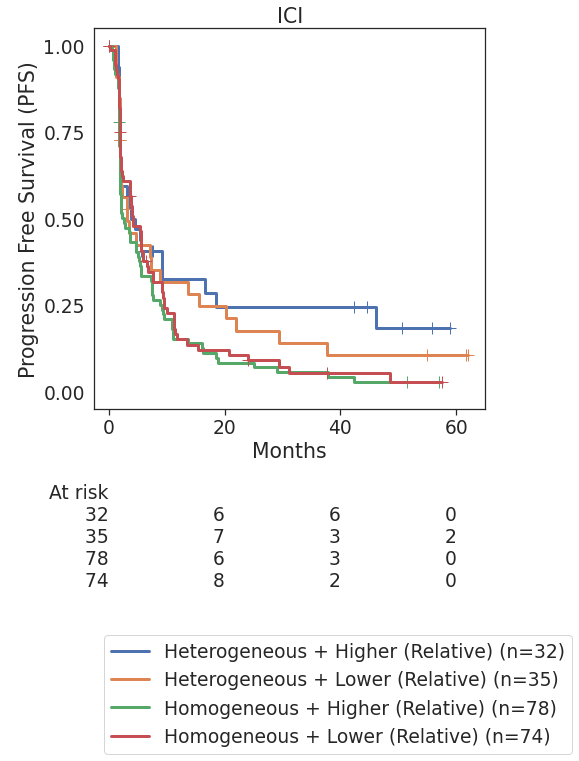

('Heterogeneous', 'Higher (Relative)') Heterogeneous + Higher (Relative) (n=43)
('Heterogeneous', 'Lower (Relative)') Heterogeneous + Lower (Relative) (n=40)
('Homogeneous', 'Higher (Relative)') Homogeneous + Higher (Relative) (n=66)
('Homogeneous', 'Lower (Relative)') Homogeneous + Lower (Relative) (n=71)


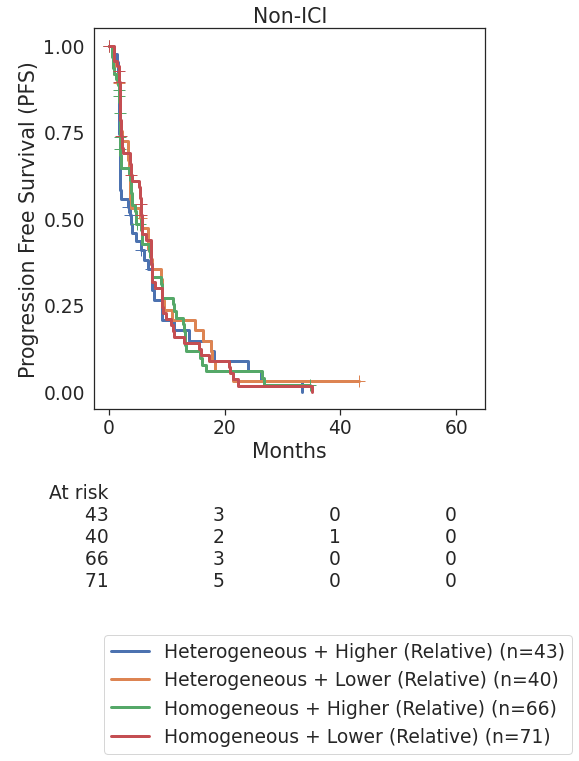

In [49]:
# %%capture
set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

### assign relative quantile bins per presence of heterogeneity
qbins = temp.groupby(['any_diff_edge']).apply(lambda x: get_qbins_simple(x, 'nonstroma_grade_mean',2))

subgroupqbins = pd.concat([x[0] for x in qbins.to_dict().values()])

temp['subgroup_qbin'] = subgroupqbins
temp['subgroup_qbin'] = temp['subgroup_qbin'].map({0:'Lower (Relative)', 1:'Higher (Relative)'})

cols = ['Grade Heterogeneity','subgroup_qbin']

for duration_var in ['os','pfs']:
    construct_duo_wrapper(temp.dropna(subset=[duration_var]), cols, f'./main_figs/[split_km]cm025_any_diff_edge_subgroupqbin2_{duration_var}',
                         ['ICI','Non-ICI'], 'drug_type', duration_var=duration_var, ci_show=False, ax=plt.gca(), rows_to_show=['At risk'], duration_max=CM_DURATION_MAX, at_risk_labels = ['','','',''])

### CM025: HG edge only for CM025; Joint edge + TIL

In [50]:
%%capture
drug_type = 'any'
outcome_type = 'benefit'
duration_var = 'os'
mandatory_vars = []
drop_g1 = True
drop_met_site = True
risk_type = 'MSKCC'
use_risk_group_info = False
til_only_cases = True
gene = None
drop_intermed_group = False
qbins = 2
high_grade_filter = True

temp = prepare_cm025_subset(feature_subset, anno=anno, drug_type=drug_type, mandatory_vars=mandatory_vars,
                            duration_var=duration_var, outcome_type=outcome_type, til_only_cases=til_only_cases, 
                            risk_type=risk_type, drop_met_site=drop_met_site, qbins=qbins,
                            gene=gene, drop_intermed_group=drop_intermed_group,
                           high_grade_filter=high_grade_filter)

if qbins == 3:
    temp['quantile_bin'] = temp['quantile_bin'].map({'quantile_bin_0':'Lower Grade Score', 'quantile_bin_1':'Intermed. Grade Score', 'quantile_bin_2':'Higher Grade Score'})
elif qbins == 2:
    temp['quantile_bin'] = temp['quantile_bin'].map({'quantile_bin_0':'Lower Grade Score', 'quantile_bin_1':'Higher Grade Score'})
    
temp['single_node_case'] = temp['single_node_case'].map({False:'Multifocal', True:'Single Focal'})

### CM025 Marginals [any_diff_edge] [HG/TIL passing filter]

Heterogeneous Heterogeneous (n=36)
Homogeneous Homogeneous (n=99)


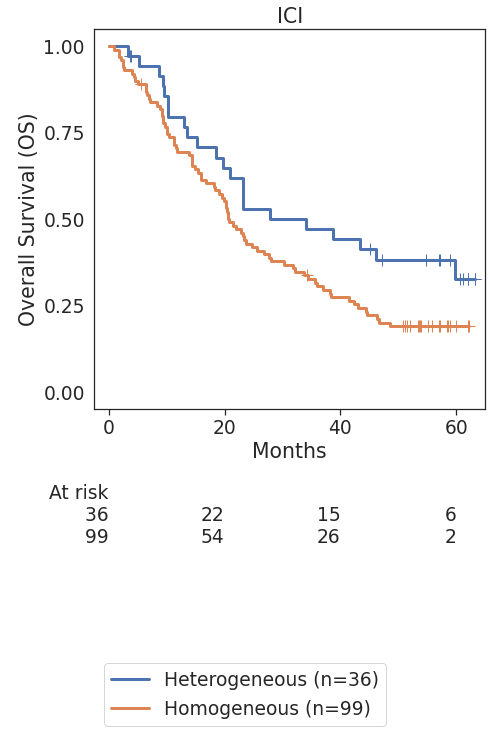

Heterogeneous Heterogeneous (n=40)
Homogeneous Homogeneous (n=88)


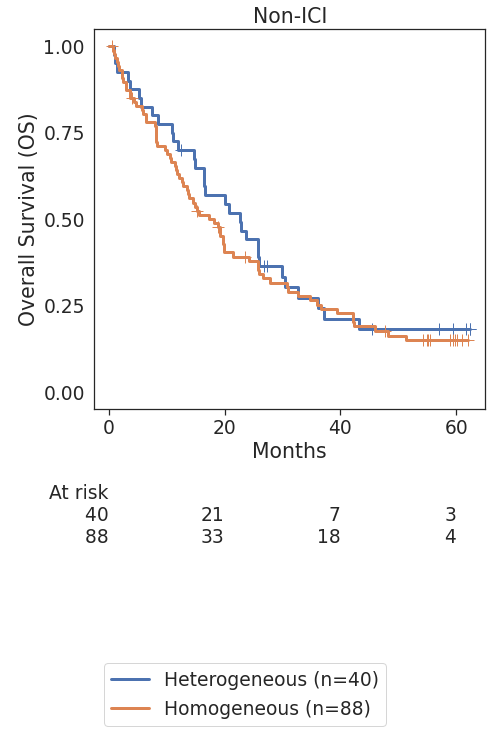

Heterogeneous Heterogeneous (n=36)
Homogeneous Homogeneous (n=99)


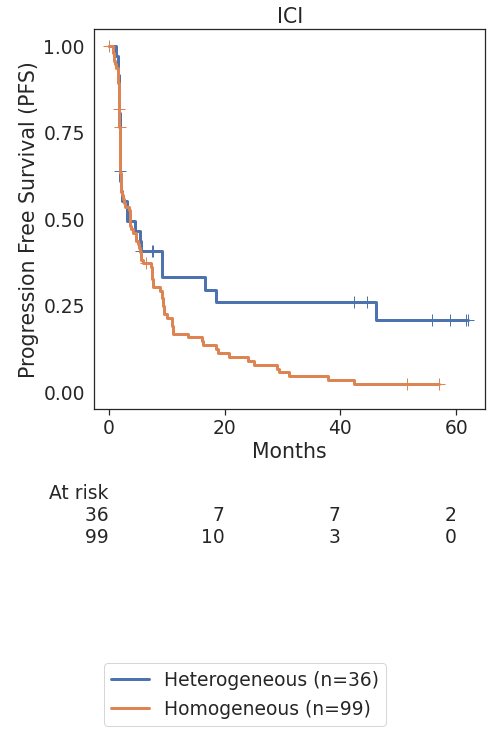

Heterogeneous Heterogeneous (n=40)
Homogeneous Homogeneous (n=88)


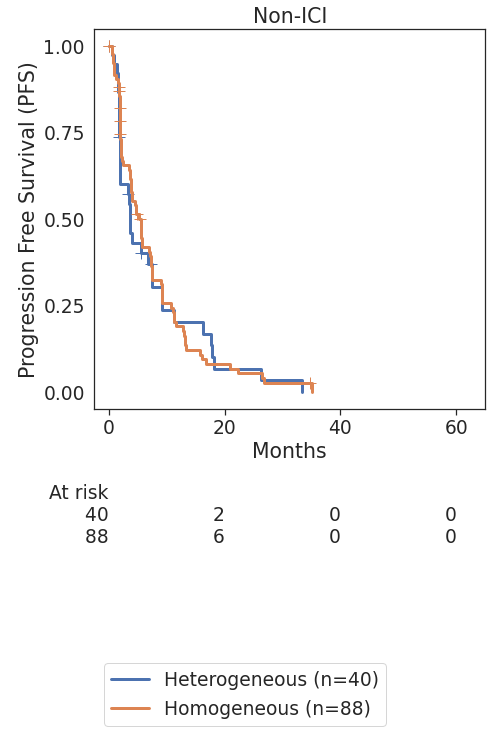

In [51]:
# %%capture
set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

temp['Grade Heterogeneity'] = temp['any_diff_edge']
temp['Grade Heterogeneity'] = temp['Grade Heterogeneity'].map({'Low/Hi Presence':'Heterogeneous', 'No Mixed Foci Presence':'Homogeneous'})

temp['Global Infiltration'] = temp['global_infiltration_bin']
temp['Global Infiltration'] = temp['Global Infiltration'].map({'high_hg_global_infiltration':'High Infiltration', 'low_hg_global_infiltration':'Low Infiltration'})


cols = ['Grade Heterogeneity']

for duration_var in ['os','pfs']:
    construct_duo_wrapper(temp.dropna(subset=[duration_var]), cols, f'./supp_figs/[split_km]cm025_any_diff_edge_hg_passing_{duration_var}',
                         ['ICI','Non-ICI'], 'drug_type', duration_var=duration_var, ci_show=False, ax=plt.gca(), rows_to_show=['At risk'], duration_max=CM_DURATION_MAX, at_risk_labels = ['','','',''])

### CM025 Marginals [any_hg_diff_edge] [HG/TIL passing filter]

Heterogeneous Heterogeneous (n=32)
Homogeneous Homogeneous (n=103)


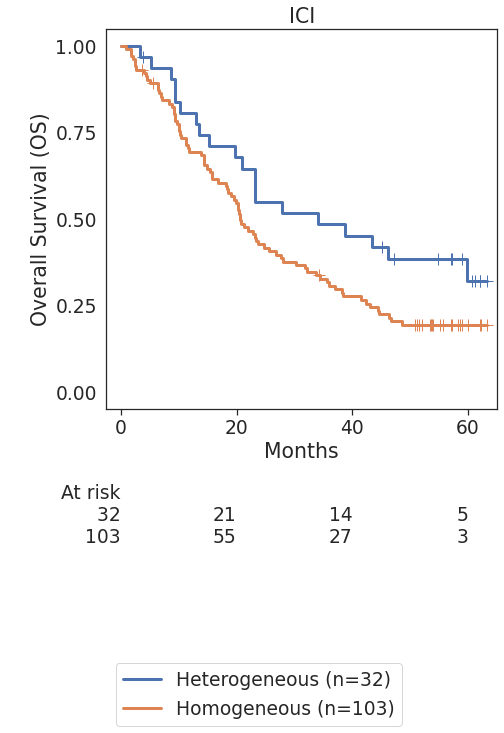

Heterogeneous Heterogeneous (n=40)
Homogeneous Homogeneous (n=88)


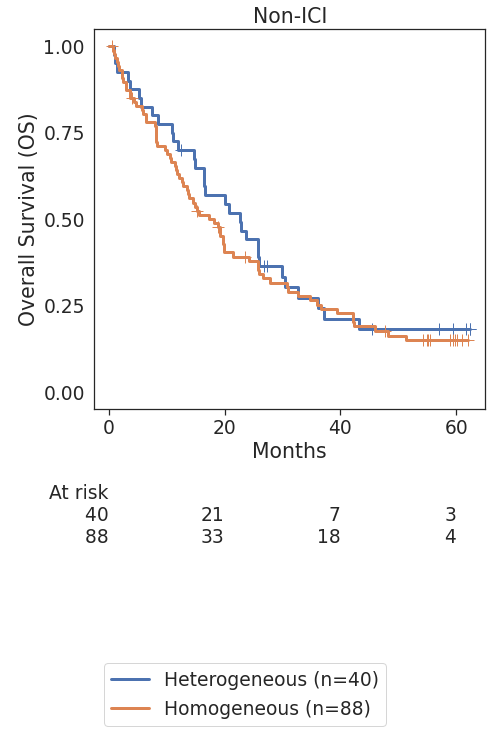

Heterogeneous Heterogeneous (n=32)
Homogeneous Homogeneous (n=103)


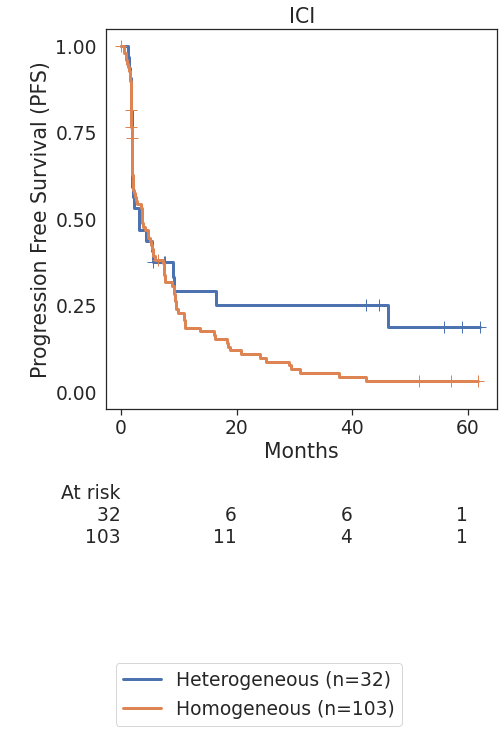

Heterogeneous Heterogeneous (n=40)
Homogeneous Homogeneous (n=88)


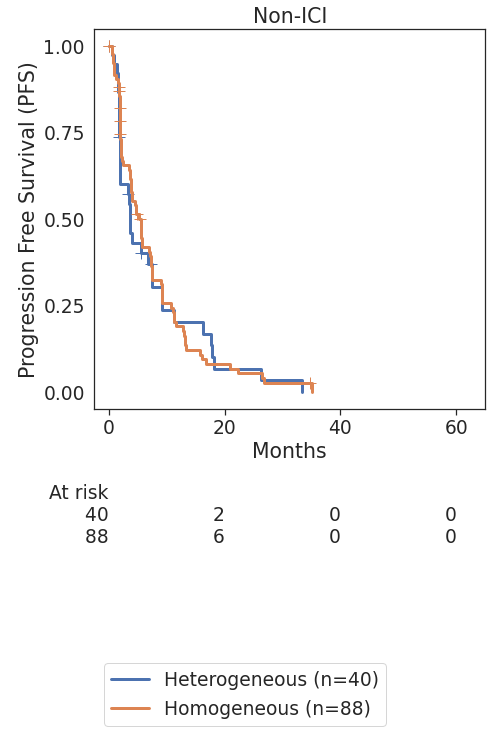

In [52]:
# %%capture
set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

temp['Grade Heterogeneity'] = temp['any_hg_diff_edge']
temp['Grade Heterogeneity'] = temp['Grade Heterogeneity'].map({'high_grade_diff_edge':'Heterogeneous', 'no_high_grade_diff_edge':'Homogeneous'})

temp['Global Infiltration'] = temp['global_infiltration_bin']
temp['Global Infiltration'] = temp['Global Infiltration'].map({'high_hg_global_infiltration':'High Infiltration', 'low_hg_global_infiltration':'Low Infiltration'})

cols = ['Grade Heterogeneity']

for duration_var in ['os','pfs']:
    construct_duo_wrapper(temp.dropna(subset=[duration_var]), cols, f'./main_figs/[split_km]cm025_any_hg_diff_edge_hg_passing_{duration_var}',
                         ['ICI','Non-ICI'], 'drug_type', duration_var=duration_var, ci_show=False, ax=plt.gca(), rows_to_show=['At risk'], duration_max=CM_DURATION_MAX, at_risk_labels = ['','','',''])

### CM025 Marginals [global_infiltration] [HG/TIL passing filter]

High Infiltration High Infiltration (n=72)
Low Infiltration Low Infiltration (n=63)


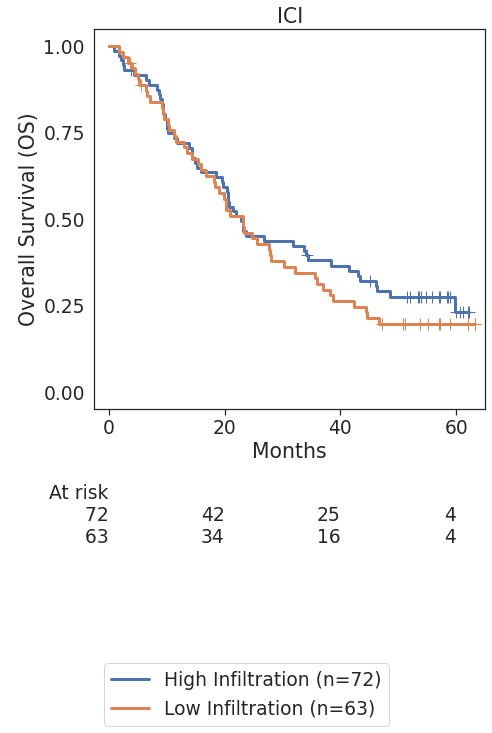

High Infiltration High Infiltration (n=60)
Low Infiltration Low Infiltration (n=68)


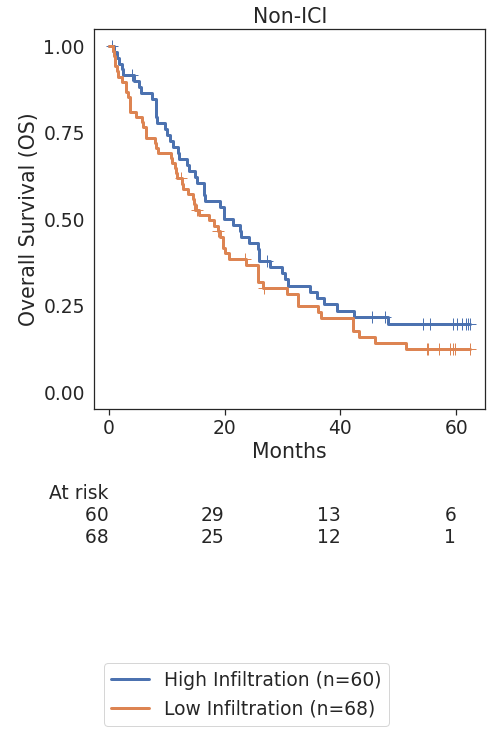

High Infiltration High Infiltration (n=72)
Low Infiltration Low Infiltration (n=63)


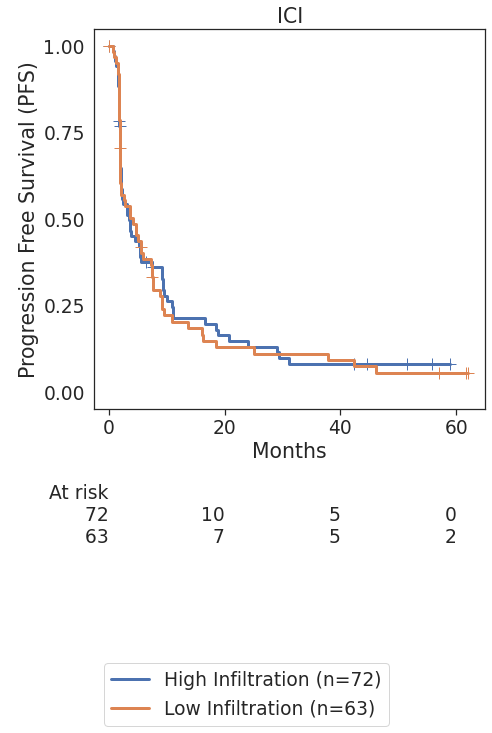

High Infiltration High Infiltration (n=60)
Low Infiltration Low Infiltration (n=68)


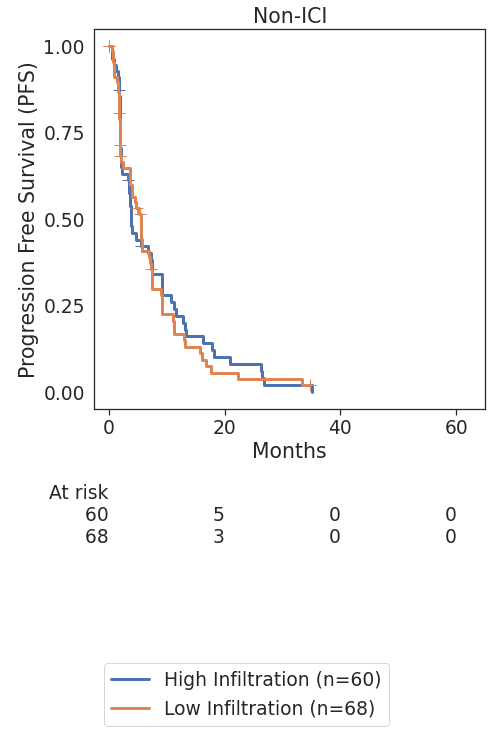

In [53]:
# %%capture
set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

temp['Grade Heterogeneity'] = temp['any_diff_edge']
temp['Grade Heterogeneity'] = temp['Grade Heterogeneity'].map({'Low/Hi Presence':'Heterogeneous', 'No Mixed Foci Presence':'Homogeneous'})

temp['Global Infiltration'] = temp['global_infiltration_bin']
temp['Global Infiltration'] = temp['Global Infiltration'].map({'high_hg_global_infiltration':'High Infiltration', 'low_hg_global_infiltration':'Low Infiltration'})

cols = ['Global Infiltration']

for duration_var in ['os','pfs']:
    construct_duo_wrapper(temp.dropna(subset=[duration_var]), cols, f'./main_figs/[split_km]cm025_global_infiltration_hg_passing_{duration_var}',
                         ['ICI','Non-ICI'], 'drug_type', duration_var=duration_var, ci_show=False, ax=plt.gca(), rows_to_show=['At risk'], duration_max=CM_DURATION_MAX, at_risk_labels = ['','','',''])

### CM025 Joint [any_hg_diff_edge + global_infiltration] [HG/TIL passing filter]

('Heterogeneous', 'High Infiltration') Heterogeneous + High Infiltration (n=17)
('Heterogeneous', 'Low Infiltration') Heterogeneous + Low Infiltration (n=15)
('Homogeneous', 'High Infiltration') Homogeneous + High Infiltration (n=55)
('Homogeneous', 'Low Infiltration') Homogeneous + Low Infiltration (n=48)


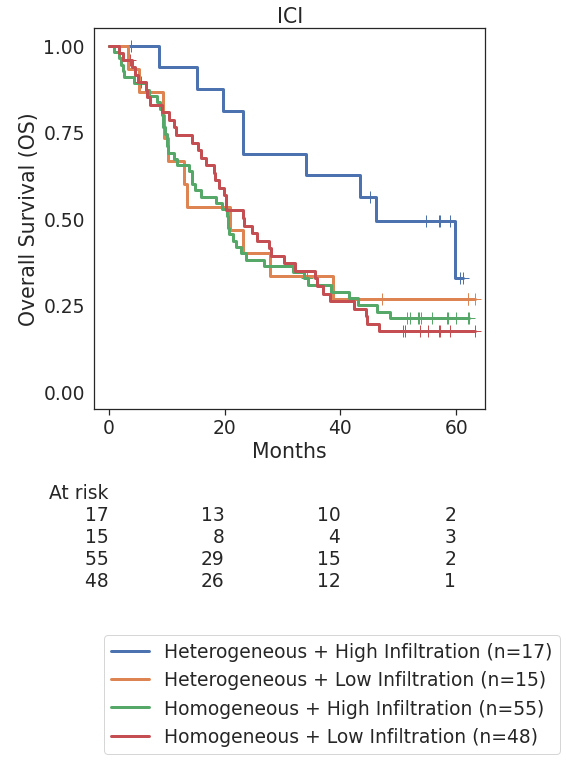

('Heterogeneous', 'High Infiltration') Heterogeneous + High Infiltration (n=21)
('Heterogeneous', 'Low Infiltration') Heterogeneous + Low Infiltration (n=19)
('Homogeneous', 'High Infiltration') Homogeneous + High Infiltration (n=39)
('Homogeneous', 'Low Infiltration') Homogeneous + Low Infiltration (n=49)


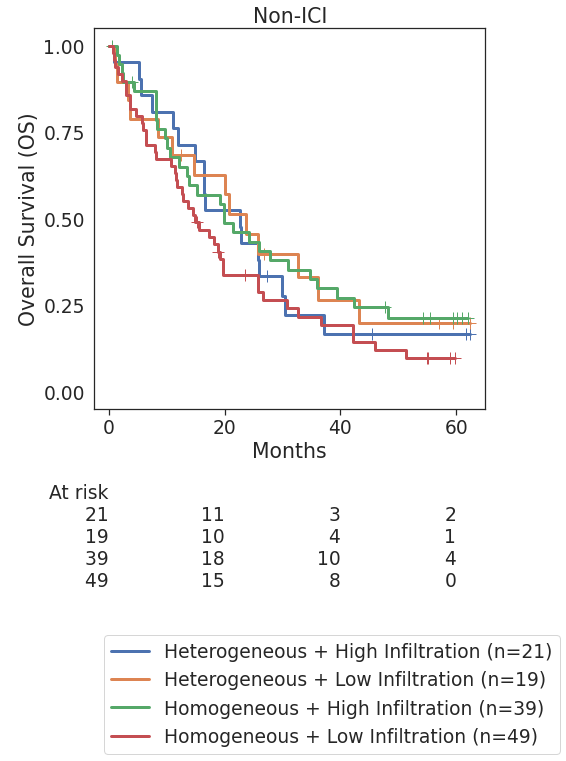

('Heterogeneous', 'High Infiltration') Heterogeneous + High Infiltration (n=17)
('Heterogeneous', 'Low Infiltration') Heterogeneous + Low Infiltration (n=15)
('Homogeneous', 'High Infiltration') Homogeneous + High Infiltration (n=55)
('Homogeneous', 'Low Infiltration') Homogeneous + Low Infiltration (n=48)


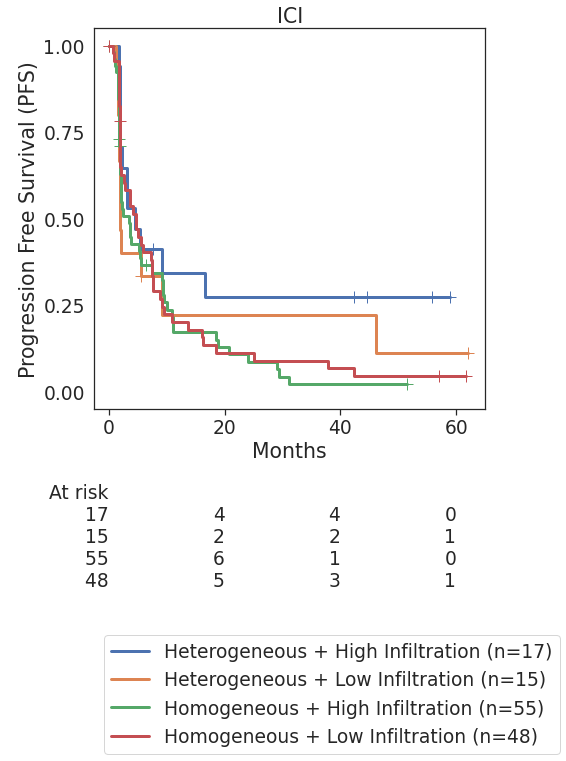

('Heterogeneous', 'High Infiltration') Heterogeneous + High Infiltration (n=21)
('Heterogeneous', 'Low Infiltration') Heterogeneous + Low Infiltration (n=19)
('Homogeneous', 'High Infiltration') Homogeneous + High Infiltration (n=39)
('Homogeneous', 'Low Infiltration') Homogeneous + Low Infiltration (n=49)


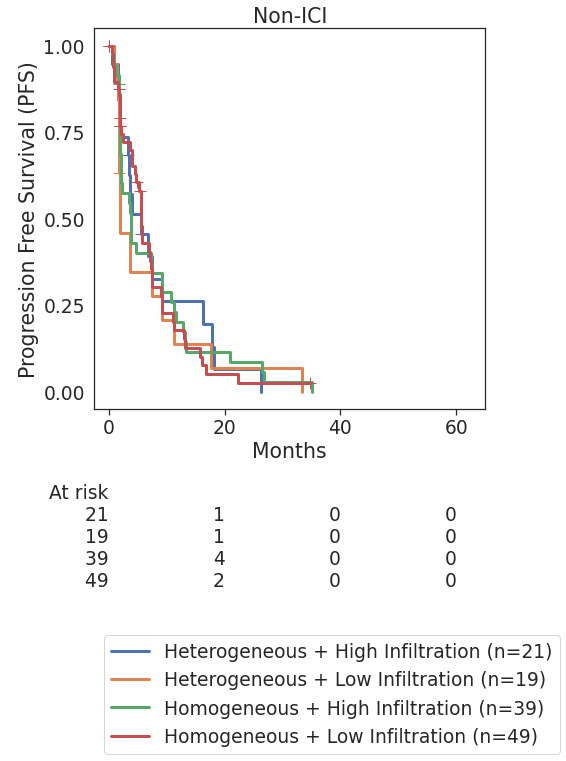

In [54]:
# %%capture
set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

temp['Grade Heterogeneity'] = temp['any_hg_diff_edge']
temp['Grade Heterogeneity'] = temp['Grade Heterogeneity'].map({'high_grade_diff_edge':'Heterogeneous', 'no_high_grade_diff_edge':'Homogeneous'})

temp['Global Infiltration'] = temp['global_infiltration_bin']
temp['Global Infiltration'] = temp['Global Infiltration'].map({'high_hg_global_infiltration':'High Infiltration', 'low_hg_global_infiltration':'Low Infiltration'})

cols = ['Grade Heterogeneity','Global Infiltration']

for duration_var in ['os','pfs']:
    construct_duo_wrapper(temp.dropna(subset=[duration_var]), cols, f'./main_figs/[split_km]cm025_hg_gradehet_globalinfilt_{duration_var}',
                         ['ICI','Non-ICI'], 'drug_type', duration_var=duration_var, ci_show=False, ax=plt.gca(), rows_to_show=['At risk'], duration_max=CM_DURATION_MAX, at_risk_labels = ['','','',''])

In [55]:
# # %%capture
# set_rc(KM_SINGLE_SIZE, KM_SINGLE_SIZE,KM_FONT_SCALE)

# temp['Grade Heterogeneity'] = temp['any_hg_diff_edge']
# temp['Grade Heterogeneity'] = temp['Grade Heterogeneity'].map({'high_grade_diff_edge':'Heterogeneous', 'no_high_grade_diff_edge':'Homogeneous'})

# temp['Global Infiltration'] = temp['global_infiltration_bin']
# temp['Global Infiltration'] = temp['Global Infiltration'].map({'high_hg_global_infiltration':'High Infiltration', 'low_hg_global_infiltration':'Low Infiltration'})

# cols = ['Grade Heterogeneity','Global Infiltration']

# temp['drug_type_rename'] = temp['drug_type'].map({'ICI':'Anti-PD1 treatment (ICI)','Non-ICI':'mTOR inhibition (Non-ICI)'})

# for duration_var in ['os','pfs']:
#     construct_duo_wrapper(temp.dropna(subset=[duration_var]), cols, f'./test_{duration_var}',
#                          ['Anti-PD1 treatment (ICI)','mTOR inhibition (Non-ICI)'], 'drug_type_rename', 
#                           duration_var=duration_var, ci_show=False, ax=plt.gca(), rows_to_show=['At risk'], duration_max=CM_DURATION_MAX, at_risk_labels = ['','','',''])

### Supplement regen

#### Grab Bi supplement again

In [56]:
kbi_supp_tcga = pd.read_excel('/home/jupyter/TableS5_Submit.xlsx', sheet_name=3, header=1).set_index(['Patient'])

final_supp = pd.read_excel('/home/jupyter/TableS5_ReSubmit_FInalized.xlsx', sheet_name=2, header=1)
final_supp['subjid'] = final_supp['SUBJID'].apply(lambda x: x.split('-')[1])

prev_cm025_scores = final_supp.set_index('subjid')[['TP1 Score', 'TP2 Score', 'Immune Checkpoint/Evasion Score']]
prev_cm025_scores.index = 'cm025_' + prev_cm025_scores.index.astype(str)
prev_scores = pd.concat([kbi_supp_tcga[['TP1 Score', 'TP2 Score',]], prev_cm025_scores])
    
prev_comparison = feature_subset.copy()
prev_comparison = prev_comparison.join(prev_scores)
prev_comparison['tp1_tp2_diff_prev'] = prev_comparison['TP1 Score']- prev_comparison['TP2 Score']

#### Grab Braun supplement again

In [57]:
final_supp = final_supp.set_index('subjid')
final_supp.index = 'cm025_' + final_supp.index.astype(str)
final_supp['tp1_high'] = final_supp['TP1 Score'] > final_supp['TP1 Score'].median()
final_supp = final_supp.join(anno['PBRM1'])

final_supp['n_prio_tx_above_1'] = final_supp['Number_of_Prior_Therapies'] > 1
final_supp['n_prio_tx_above_1'] = final_supp['n_prio_tx_above_1'].astype(str)

final_supp.index.name = 'unique_id'

#### Read Braun RNA data and merge

In [58]:
rna = pd.read_csv('../braun2020_rna_only.csv', index_col=0).transpose()
rna.index.name = 'fid'

index_key = reset_set_idx(final_supp, 'Sample')['unique_id']
paired_rna = rna.join(index_key).dropna(subset=['unique_id'])
paired_rna = paired_rna.set_index('unique_id')

#### Merge and reformat

In [59]:
feature_subset = merge_nonoverlapping(feature_subset, prev_scores)
feature_subset = feature_subset.join(anno[['Received_Prior_Therapy','Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy']])

feature_subset['tp1_score'] = feature_subset['TP1 Score']
feature_subset['tp2_score'] = feature_subset['TP2 Score']

feature_subset = feature_subset.join(anno['Number_of_Prior_Therapies'])

feature_subset.loc[feature_subset['Number_of_Prior_Therapies'] <= 1, 'n_prior_therapy'] = 'one_or_less'
feature_subset.loc[feature_subset['Number_of_Prior_Therapies'] > 1, 'n_prior_therapy'] = 'more_than_one'

feature_subset['tp1_available'] = ~feature_subset['TP1 Score'].isna()

In [60]:
feature_subset['ith'].dropna()

unique_id
TCGA-3Z-A93Z    0.056911
TCGA-6D-AA2E    0.147368
TCGA-A3-3316    0.029703
TCGA-A3-3319    0.116667
TCGA-A3-3322    0.274809
                  ...   
cm025_984       0.097222
cm025_986       0.274419
cm025_992       0.631313
cm025_996       0.225806
cm025_997       0.327869
Name: ith, Length: 726, dtype: float64

In [61]:
feature_subset['wgii']

unique_id
TCGA-3Z-A93Z       0.186038
TCGA-6D-AA2E       0.001755
TCGA-A3-3307            NaN
TCGA-A3-3308            NaN
TCGA-A3-3311            NaN
                     ...   
profile_1096806         NaN
profile_1096876         NaN
profile_1096917         NaN
profile_1097026         NaN
profile_1098041         NaN
Name: wgii, Length: 1392, dtype: float64

In [62]:
df = pd.concat([kirc_data, checkmate_data])

In [63]:
%%capture
qbins = 2
df = pd.concat([
    prepare_generic_subset(feature_subset, 'kirc', relabel_edge_cats=False, qbins=qbins),
    prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=False, qbins=qbins),
])
df['any_diff_edge'] = df['any_diff_edge'].map({False:'Homogeneous',True:'Heterogeneous'})
df['Grade-Heterogeneity'] = df['any_diff_edge']
df['Microheterogeneity'] = df['any_diff_edge']

df['Cohort'] = df['cohort'].str.upper()
df['Cohort'] = df['Cohort'].replace({'KIRC':'TCGA-KIRC','CM025':'CM-025'})


df['wGII'] = df['wgii']
df['ITH (TRACERx)'] = df['ith']

qbins = df.groupby(['any_diff_edge']).apply(lambda x: get_qbins_simple(x, 'nonstroma_grade_mean',2))
subgroupqbins = pd.concat([x[0] for x in qbins.to_dict().values()])

df['subgroup_qbin'] = subgroupqbins
df['subgroup_qbin'] = df['subgroup_qbin'].map({0:'Lower Grade (Relative)', 1:'Higher Grade (Relative)'})
df['quantile_bin'] = map_qbins_to_label(df['quantile_bin'],2)

In [64]:
%%capture
for cohort in ['TCGA-KIRC','CM-025']:
    for col in ['subgroup_qbin','quantile_bin']:
        for metric in ['wGII','ITH (TRACERx)']:
            plot_kws = {
                'order':None,
                'x':'Microheterogeneity',
                'y':metric,
                'hue':col,
                'hue_order':None,
                'data':df.loc[(df['Cohort'] == cohort) & (df[metric] < df[metric].quantile(0.99))
                             ],
            }

            set_rc(8,8, 2)
            g = sns.boxplot(**plot_kws)
            a = list((product( df[plot_kws['x']].unique(), df[plot_kws['hue']].unique(),)))
            pairs = list(combinations(a, 2))
            annotator = Annotator(g, pairs, **plot_kws)
            annotator.configure(test='Mann-Whitney', text_format='star')
            annotator.apply_and_annotate()
            plt.title(f'{metric}\n{cohort.upper()}')
            move_leg(g)
            
            plt.savefig(f'./supp_figs/{cohort}_any_diff_edge_vs_{metric}_vs_{col}_boxplot.pdf', bbox_inches='tight')
            plt.show()

In [65]:
df['tp1_tp2_diff'] = df['tp1_score'] - df['tp2_score']
df['Grade Score'] = df['nonstroma_grade_mean']
df['TP1 - TP2'] = df['tp1_tp2_diff']

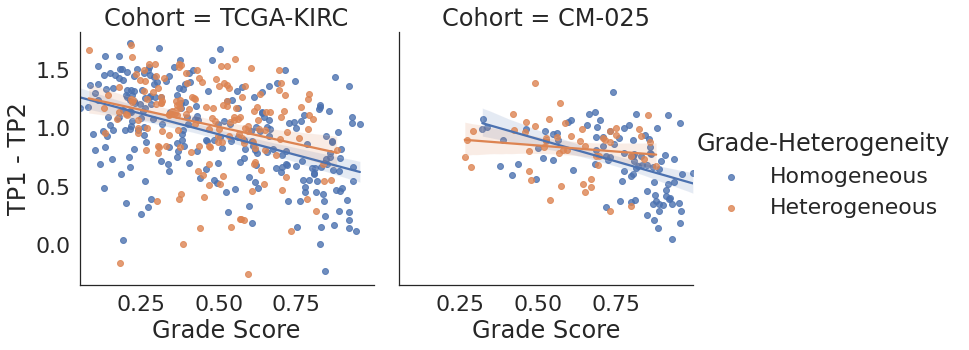

In [66]:
sns.lmplot(x='Grade Score',y='TP1 - TP2', data=df, col='Cohort', hue='Grade-Heterogeneity')
plt.savefig(f'./supp_figs/{cohort}_any_diff_edge_vs_gradescore_vs_tp1tp2_boxplot.pdf', bbox_inches='tight')

In [67]:
df2 = df.join(anno[['Angio', 'Teff', 'Myeloid', 'Javelin','Merck18']])

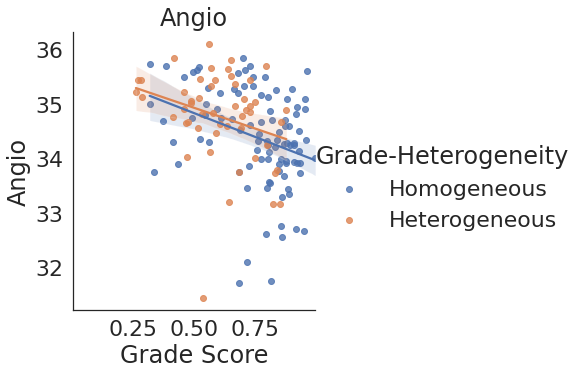

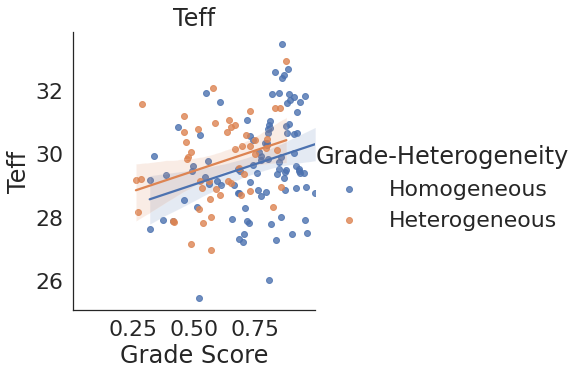

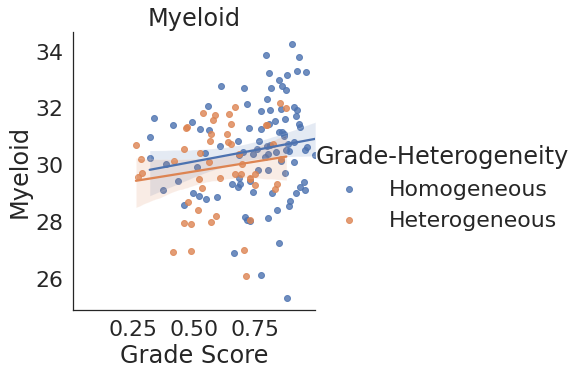

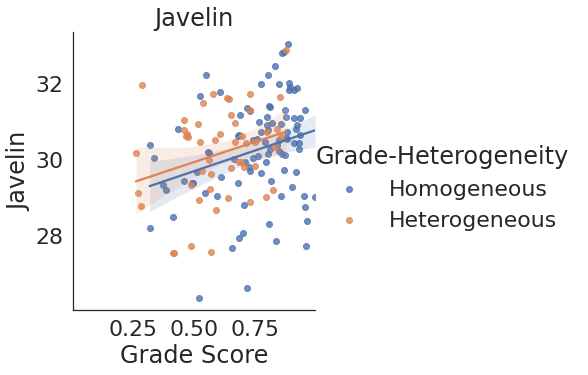

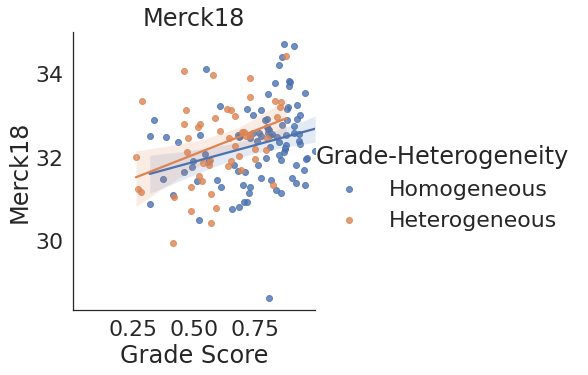

In [68]:
for signature in ['Angio', 'Teff', 'Myeloid', 'Javelin','Merck18']:
    sns.lmplot(x='Grade Score',y=signature, data=df2, hue='Grade-Heterogeneity')
    plt.title(signature)
    plt.savefig(f'./supp_figs/cm25_{signature}_signature_vs_gradescore_vs_any_diff_edge.pdf', bbox_inches='tight')
    plt.show()

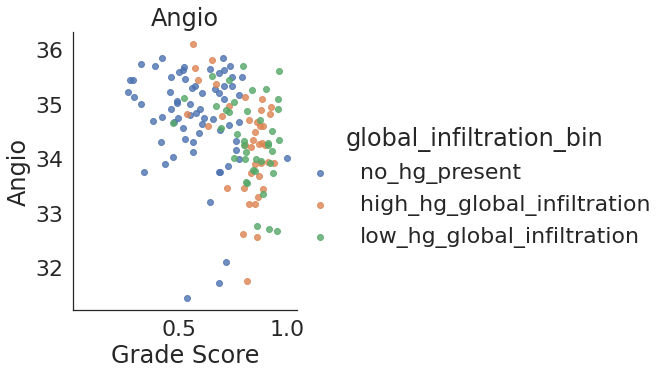

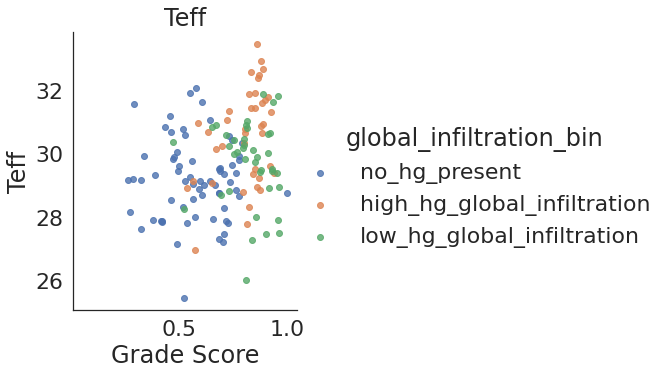

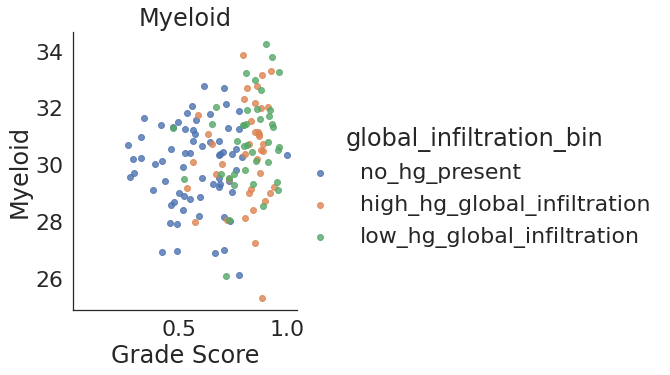

In [ ]:
for signature in ['Angio', 'Teff', 'Myeloid', 'Javelin','Merck18']:
    sns.lmplot(x='Grade Score',y=signature, data=df2, hue='global_infiltration_bin', fit_reg=False)
    plt.title(signature)
    plt.savefig(f'./supp_figs/cm25_{signature}_signature_vs_gradescore_vs_global_infilt.pdf', bbox_inches='tight')    
    plt.show()


In [ ]:
pause

---

In [ ]:
df3 = df.join(pd.read_pickle('./rerun_kirc_rna_signature_info.pkl')[['javelin_angio_score', 'mcderm_angio_sig', 'mcderm_teff_sig', 'mcderm_myeloid_sig']])

In [ ]:
df3 = df3.dropna(subset=['javelin_angio_score', 'mcderm_angio_sig', 'mcderm_teff_sig', 'mcderm_myeloid_sig'])

In [ ]:
for signature in ['javelin_angio_score', 'mcderm_angio_sig', 'mcderm_teff_sig', 'mcderm_myeloid_sig']:
    sns.lmplot(x='Grade Score',y=signature, data=df3, hue='Grade-Heterogeneity', fit_reg=True)
    plt.title(signature)
    plt.show()
    # plt.savefig(f'./supp_figs/{cohort}_any_diff_edge_vs_gradescore_vs_tp1tp2_boxplot.pdf', bbox_inches='tight')

In [ ]:
df['combined_f_weighted_edge_score'] = df['edge_class_proximal_f_weighted'] + df['edge_class_distal_f_weighted']
df['combined_total_weighted_edge_score'] = df['edge_class_proximal_total_weighted'] + df['edge_class_distal_total_weighted']

In [ ]:
sns.lmplot(x='ith',y='combined_total_weighted_edge_score', data=df.loc[df['ith'] < df['ith'].quantile(0.95)], col='cohort')

In [ ]:
sns.lmplot(x='wgii',y='combined_total_weighted_edge_score', data=df.loc[df['ith'] < df['ith'].quantile(0.95)], col='cohort')

In [ ]:
sns.lmplot(x='wgii',y='combined_f_weighted_edge_score', data=df.loc[df['ith'] < df['ith'].quantile(0.95)], col='cohort')

In [ ]:
df['combined_total_weighted_edge_score'].max()

In [ ]:
df['edge_class_proximal_total_weighted'].max()

In [ ]:
df['edge_class_distal_total_weighted'].max()

In [ ]:
df['edge_class_proximal_f_weighted'].max()

In [ ]:
df['edge_class_distal_f_weighted'].max()

In [ ]:
df['edge_class_proximal']

In [ ]:
df['tile_count']/df['tile_count'].mean()

In [ ]:
(df['tile_count']-df['tile_count'].mean())/df['tile_count'].std()

In [ ]:
((df['tile_count']-df['tile_count'].mean())/df['tile_count'].std()).std()

In [ ]:
df['normed_tiled_count'] = (df['tile_count']-df['tile_count'].mean())/df['tile_count'].std()

In [ ]:
df['normed_tiled_count'].hist()

In [ ]:
sns.lmplot(y='edge_class_proximal', x='normed_tiled_count', data=df, col='cohort')

In [ ]:
sns.lmplot(y='edge_class_distal', x='normed_tiled_count', data=df, col='cohort')

In [ ]:
sns.lmplot(y='all_rag_edge_total', x='normed_tiled_count', data=df, col='cohort')

In [ ]:
sns.lmplot(y='combined_total_weighted_edge_score', x='normed_tiled_count', data=df, col='cohort')

In [ ]:
(df['tile_count']/df['tile_count'].max()).hist()

In [ ]:
sns.lmplot(x='wgii',y='all_rag_edge_total', data=df.loc[df['ith'] < df['ith'].quantile(0.95)], col='cohort')

In [ ]:
sns.lmplot(x='ith',y='all_rag_edge_total', data=df.loc[df['ith'] < df['ith'].quantile(0.95)], col='cohort')

In [ ]:
sns.lmplot(x='ith',y='nonstroma_grade_mean', data=df.loc[df['ith'] < df['ith'].quantile(0.95)], col='cohort')

In [ ]:
sns.lmplot(y='wgii',x='nonstroma_grade_mean', data=df.loc[df['ith'] < df['ith'].quantile(0.99)], col='cohort')

In [ ]:
sns.lmplot(y='wgii',x='nonstroma_grade_mean', data=df.loc[df['ith'] < df['ith'].quantile(0.99)], col='cohort')

In [ ]:
sns.lmplot(y='wgii',x='nonstroma_grade_mean', data=df.loc[df['ith'] < df['ith'].quantile(0.99)], col='cohort', row='any_diff_edge')

In [ ]:
sns.lmplot(y='ith',x='nonstroma_grade_mean', data=df.loc[df['ith'] < df['ith'].quantile(0.99)], col='cohort', row='any_diff_edge')

In [ ]:
df['edge_class_proximal']

In [ ]:
set_rc()
anno['ITH'].hist()

In [ ]:
feature_subset.loc[feature_subset['cohort'] == 'cm025']['ith'].dropna().describe()

In [ ]:
anno['ITH'].dropna().describe()

In [ ]:
feature_subset.loc[feature_subset['cohort'] == 'cm025']['wgii'].dropna().describe()

In [ ]:
anno['WGII'].dropna().describe()

In [ ]:
kirc_scores = pd.read_csv('/home/jupyter/20210308_kirc_wgii_ith_scores.csv')
bms_ith_recalc = pd.read_csv('/home/jupyter/20210308_bms_all_cohorts_ith_score_describe_ccf_mod.csv')

In [ ]:
x = feature_subset.join(anno['ITH'])

In [ ]:
sns.lmplot('ITH','ith', x)

In [ ]:
sns.lmplot('ITH','ith', x.loc[x['ith'] < x['ith'].quantile(0.90)])

---
### CPH Coefficient Plots (generated/repasted from `minimal_cph_modeling`)

In [ ]:
set_rc(12,25, 1.5)
reg_sweep = {
    'default':{'penalizer':0.1, 'l1_ratio':0.1},
}
cph_results = torch.load('./[rerun] cm025 CPH sweep fitter results.pkl')['nontil']
result_agg = pd.read_csv('./[rerun] cm025_cph_sweep_results_unfiltered.csv',index_col=0)

form_map = {
    'only_clinical_vars':'MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy',
    'clinical_vars_and_binary_het':'MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_diff_edge + nonstroma_grade_mean',
    'clinical_vars_and_continuous_het':'MSKCC + age_at_diagnosis + gender + n_prior_therapy + combined_total_weighted_edge_score + nonstroma_grade_mean',
}

for name, form in form_map.items():
    print(name)
    for k,v in reg_sweep.items():
        print(k)
        penalizer = v['penalizer']
        l1_ratio = v['l1_ratio']


        fig, axes = plt.subplots(2,1, sharex=True, sharey=False)
        crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'ICI')
        crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
        cindex=result_agg.loc[crit].loc[form,'concordance_index_']
        
        subresult = cph_results['os_ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}']
        pval = subresult.log_likelihood_ratio_test().summary['p'].item()
        axes[0].set_title(f'ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}; LLRT p-value: {pval :.2e}')
        subresult.plot(ax=axes[0])

        crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'Non-ICI')
        crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
        cindex=result_agg.loc[crit].loc[form,'concordance_index_']
        
        subresult = cph_results['os_Non-ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}']
        pval = subresult.log_likelihood_ratio_test().summary['p'].item()
        axes[1].set_title(f'Non-ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}; LLRT p-value: {pval :.2e}')
        subresult.plot(ax=axes[1])

        plt.savefig(f'./main_figs/simple_cph_comparison_no_interaction_NONTIL __ {name} __ Penalizer {penalizer}, L1 Ratio {l1_ratio}.png', bbox_inches='tight')
        plt.show()

In [ ]:
set_rc(12,25, 1.5)
reg_sweep = {
    'default':{'penalizer':0.1, 'l1_ratio':0.1},
}
cph_results = torch.load('./[rerun] cm025 CPH sweep fitter results.pkl')['til']
result_agg = pd.read_csv('./[rerun] cm025_cph_sweep_results_hg_and_til_required.csv',index_col=0)

form_map = {
    'only_clinical_vars':'MSKCC + grade + age_at_diagnosis + gender + n_prior_therapy',
    'clinical_vars_and_binary_infilt':'MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge : global_infiltration_bin + nonstroma_grade_mean',
    'clinical_vars_and_continuous_infilt':'MSKCC + age_at_diagnosis + gender + n_prior_therapy + any_hg_diff_edge + all_nodes_area_weighted + nonstroma_grade_mean',
}

for name, form in form_map.items():
    print(name)
    for k,v in reg_sweep.items():
        print(k)
        penalizer = v['penalizer']
        l1_ratio = v['l1_ratio']


        fig, axes = plt.subplots(2,1, sharex=True, sharey=False)
        crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'ICI')
        crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
        cindex=result_agg.loc[crit].loc[form,'concordance_index_']
        
        subresult = cph_results['os_ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}']
        pval = subresult.log_likelihood_ratio_test().summary['p'].item()
        axes[0].set_title(f'ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}; LLRT p-value: {pval :.2e}')
        subresult.plot(ax=axes[0])

        crit = (result_agg['penalizer'] == penalizer) & (result_agg['l1_ratio'] == l1_ratio) & (result_agg['drug_type'] == 'Non-ICI')
        crit = crit & (result_agg['duration_var'] == 'os') & (result_agg['drop_intermed_group'] == False)
        cindex=result_agg.loc[crit].loc[form,'concordance_index_']
        
        subresult = cph_results['os_Non-ICI_only_including_intermediate_benefit'][f'{form}|{penalizer}_{l1_ratio}']
        pval = subresult.log_likelihood_ratio_test().summary['p'].item()
        axes[1].set_title(f'Non-ICI, OS \n Penalizer {penalizer}, L1 Ratio {l1_ratio} \n {form} \n C-index: {cindex.round(3)}; LLRT p-value: {pval :.2e}')
        subresult.plot(ax=axes[1])

        plt.savefig(f'./main_figs/simple_cph_comparison_TIL __ {name} __ Penalizer {penalizer}, L1 Ratio {l1_ratio}.png', bbox_inches='tight')
        plt.show()